In [1]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 
import string
import scipy.stats
## plotting details
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['axes.color_cycle'] =['#d7191c','#fc8d59','#999999','#a6d96a','#1a9641','#3288bd']
matplotlib.rcParams['lines.linewidth'] = 3.0

home_dir = os.getenv("HOME")
#source activate python2
from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES

# import ibutton data cleaned and bias corrected, calculated with CharacteristicsBaltimoreUHI
tempDF=pd.read_csv('data/correctedibuttontemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')['2016-07-01':'2016-08-30']#.first()
tempDF.columns = tempDF.columns.astype(int)

filepath = '../cityheat/Bmore/2016/'
meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
# 
sun_sensors = meta[meta.sunorshade == 'sun'].index 
tempDF = tempDF.drop(sun_sensors, axis=1)

# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)

#model_bwi = pd.read_csv('data/UCM+SST_d03_allpoints_plusbwi.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')#[tempDF.index[0]:tempDF.index[-1]]

# other variables
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw

# landcover 
lcc_english = {
    #! 40 CLASS MODIS (Outside US, cats 1-20)/NLCD (US only, cats 21-40) LU characterization
    # downloaded from https://github.com/yyr/wrf/blob/master/phys/module_sf_pxlsm_data.F March 8 2018
    1: 'Evergreen Needleleaf Forest',
    2:  'Evergreen Broadleaf Forest',
    3:  'Deciduous Needleleaf Forest',
    4:   'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6:  'Closed Shrublands', 
    7:'Open Shrublands', 
    8: 'Woody Savanna', 
    9:'Savanna', 
    10: 'Grasslands', 
    11: 'Perminent Wetlands', 
    12: 'Croplands',
    13: 'Urban andBuilt-up', 
    14: 'Cropland/Natural Vegetation Mosaic', 
    15: 'Snow and Ice', 
    16: 'Barren or Sparsely Vegetated', 
    17:  'IGBP water', 
    18: 'unclassified', 
    19: 'fill value (normally ocean water)', 
    20: 'unclassified', 
    21: 'Open water', 
    22: 'Perennial Ice/snow', 
    23: 'Developed, Open space', 
    24:'Developed, Low Intensity', 
    25: 'Developed, Medium Intensity', 
    26: 'Developed, High Intensity', 
    27: 'Barren land', 
    28: 'Deciduous Forest', 
    29: 'Evergreen Forest', 
    30: 'Mixed Forest',
    31: 'Dwarf Scrub', 
    32:  'Shrub/Scrub', 
    33: 'Grassland/Herbaceous', 
    34: 'Sedge/Herbaceous',
    35: 'Lichens', 
    36: 'Moss', 
    37: 'Pasture/Hay',
    38: 'Cultivated Crops',
    39: 'Woody Wetland',
    40: 'Emergent Herbaceous Wetland',
}

lcc = pd.read_csv('data/UCM+SST_d03_landcover.csv').set_index('Unnamed: 0')# index = meta.index, columns=['LCC'])
lcc['LCC English'] =  [lcc_english[int(x)]for x in lcc.LCC]
lcc.head()
exp = 'UCM+SST'
dom = 'd03'
# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)
fname ='data/%s_%s_bwi.csv'%(exp,dom)
model_bwi = pd.read_csv(fname,parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
#model_bwi.columns = model_bwi.columns.astype(int)

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


In [148]:
# import model data generatured by ModelledCharacteristicsBaltimoreUHI.ipynb 
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model = pd.read_csv('data/UCM+SST_d03_allpoints.csv',parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
model.columns = model.columns.astype(int)
fname ='data/%s_%s_bwi.csv'%(exp,dom)
model_bwi = pd.read_csv(fname,parse_dates=['Unnamed: 0'],date_parser=date_parser).set_index('Unnamed: 0')[tempDF.index[0]:tempDF.index[-1]]
#model_bwi.columns = model_bwi.columns.astype(int)

In [51]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

In [14]:
# do DT analysis dropping sun sensors
sun_sensors = meta[meta.sunorshade == 'sun'].index

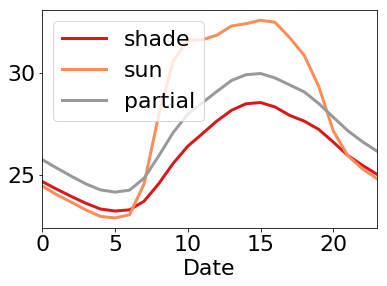

In [30]:
for meta_type in meta.sunorshade.unique(): 
    selected= meta[meta.sunorshade == meta_type].index
    tempDF[selected].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = meta_type)
    
plt.legend()

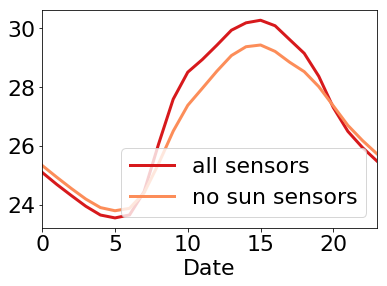

In [24]:
tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).plot()
tempDF.drop(sun_sensors, axis=1).groupby(tempDF.index.hour).mean().mean(axis=1).plot()
plt.legend(['all sensors', 'no sun sensors'])

In [103]:
# rmse
from sklearn.metrics import mean_squared_error
# correlation 
# coefficient of determination: r**2
# hit rate 
def pbias(obs, sim): 
    return 100*(sim-obs).sum()/(obs).sum()
# index of agreement
def mioa(obs,sim,  j =2): 
    return 1 - (((obs-sim)**j).sum())/( (abs(sim-obs.mean())+abs(obs-obs.mean()))**j).sum() 

In [120]:
### compute error in space 
obs = tempDF.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=0).dropna()
sim = model['2016-07-01':'2016-08-29'].mean(axis=0)[obs.index].values
obs = obs.values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF[tempDF.index.hour ==hr].loc[:'2016-08-29', model.columns].mean(axis=0).dropna()
    sim = model[model.index.hour==hr][:'2016-08-29'].mean(axis=0)[obs.index].values
    obs = obs.values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
    
for hr in ['min', 'max']: 
    obs = tempDF.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=0).dropna()
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=0)[obs.index].values
    obs=obs.values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

print('Space error: '+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' ')

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


Space error: \begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &   16 &   min &   max \\
\midrule
rmse        &      1.30 &  5.08 & 8.11 &  3.31 & 11.16 \\
correlation &      0.79 &  0.63 & 0.69 &  0.63 &  0.66 \\
p-value     &      0.00 &  0.00 & 0.00 &  0.00 &  0.00 \\
pbias       &      3.14 & -8.57 & 9.10 & -6.87 & 10.34 \\
mioa        &      0.67 &  0.52 & 0.44 &  0.56 &  0.42 \\
r\_squared   &      0.62 &  0.40 & 0.48 &  0.39 &  0.44 \\
\bottomrule
\end{tabular}



In [122]:
obs = tempDF.loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
sim = model['2016-07-01':'2016-08-29'].mean(axis=1).values

stats_df = pd.DataFrame(index = ['rmse', 'correlation', 'p-value', 'pbias' ,'mioa'])#, columns=['all data', 6, 16])
# all data 
stats_df.loc['rmse', 'all data'] = mean_squared_error(obs,sim)
stats_df.loc[['correlation', 'p-value'], 'all data'] = scipy.stats.pearsonr(obs,sim)
stats_df.loc['r_squared', 'all data'] = scipy.stats.pearsonr(obs,sim)[0]**2
stats_df.loc['pbias', 'all data'] = pbias(obs,sim)
stats_df.loc['mioa', 'all data'] = mioa(obs,sim)

# hourly data 
for hr in [6,16]: 
    obs = tempDF[tempDF.index.hour ==hr].loc['2016-07-01':'2016-08-29', model.columns].mean(axis=1).values
    sim = model[model.index.hour==hr]['2016-07-01':'2016-08-29'].mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)

for hr in ['min', 'max']: 
    obs = tempDF.loc['2016-07-01':'2016-08-29', model.columns].resample('D', how = hr).mean(axis=1).values
    sim = model['2016-07-01':'2016-08-29'].resample('D', how = hr).mean(axis=1).values
    stats_df.loc['rmse', hr] = mean_squared_error(obs,sim)
    stats_df.loc[['correlation', 'p-value'], hr] = scipy.stats.pearsonr(obs,sim)
    stats_df.loc['r_squared', hr] = scipy.stats.pearsonr(obs,sim)[0]**2
    stats_df.loc['pbias', hr] = pbias(obs,sim)
    stats_df.loc['mioa', hr] = mioa(obs,sim)
print('%Time error: \n'+  stats_df.to_latex(float_format=lambda x:'%2.2f'%x))#.replace('\n', ' ')

%Time error: 
\begin{tabular}{lrrrrr}
\toprule
{} &  all data &     6 &    16 &   min &   max \\
\midrule
rmse        &      7.21 &  6.16 & 12.27 &  5.39 & 11.40 \\
correlation &      0.86 &  0.83 &  0.77 &  0.76 &  0.92 \\
p-value     &      0.00 &  0.00 &  0.00 &  0.00 &  0.00 \\
pbias       &      3.22 & -8.54 &  9.19 & -6.85 & 10.44 \\
mioa        &      0.88 &  0.77 &  0.73 &  0.75 &  0.73 \\
r\_squared   &      0.74 &  0.69 &  0.60 &  0.57 &  0.84 \\
\bottomrule
\end{tabular}



/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


In [123]:
tempDF.max().max()

38.330258930200003

In [125]:
tempDF.min().min()

13.757734767000001

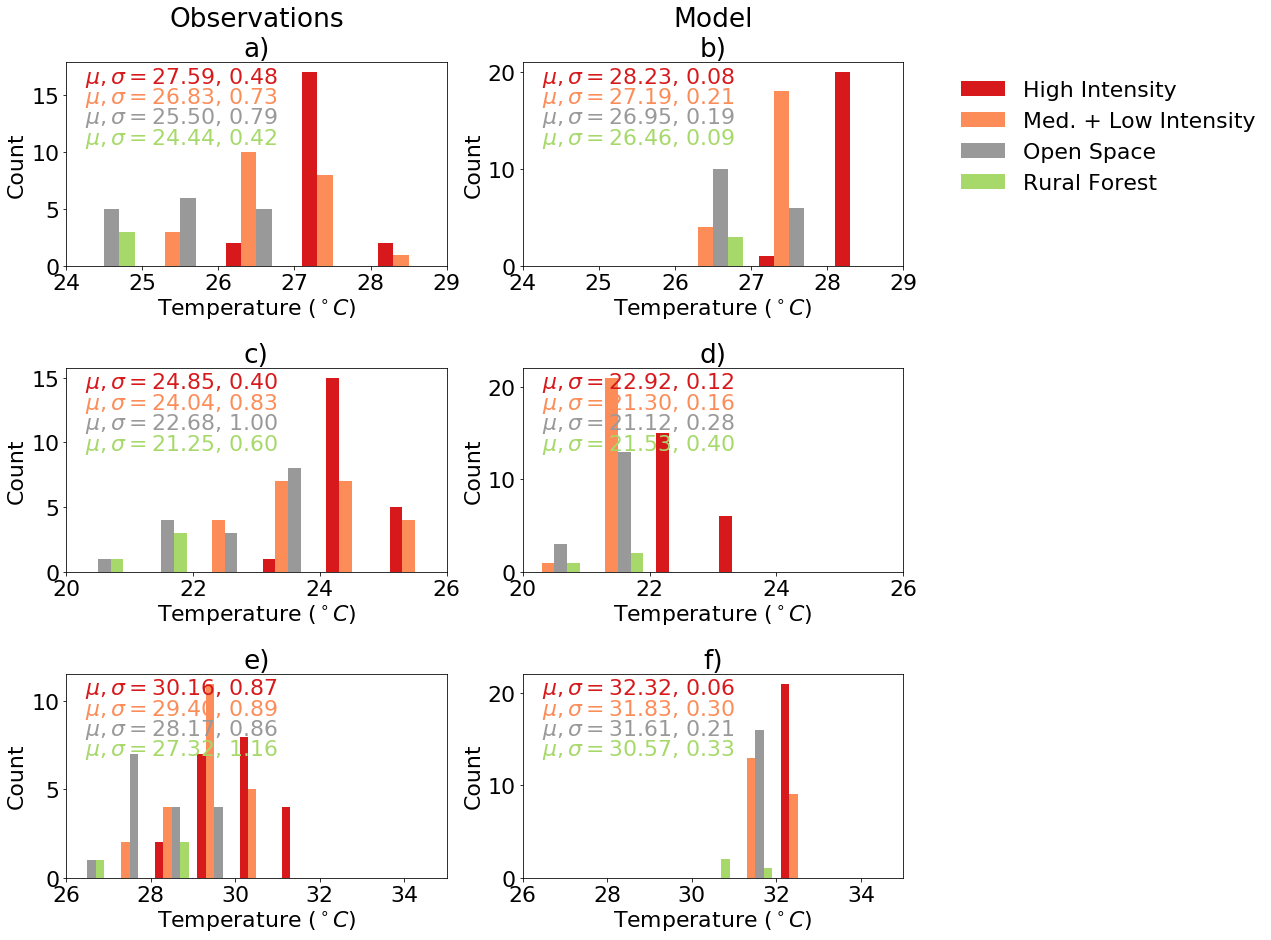

In [94]:
# Histogram of temperature by lancover type

bbins = [  np.linspace(24,29,6), np.linspace(24,29,6),# bins for all data
            np.linspace(20,26,7), np.linspace(20,26,7), # bins for 6am data
           np.linspace(26,34,9),  np.linspace(26,34,9),# bins for 4pm data]
]
iii = 1
fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[lcc[(lcc.LCC==26)].index].mean(),
        tempDF[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1

ax.hist(data, bins = bbins[0])
ax.set_title('Observations\na)')
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
#labels = ['Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']
labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
#plt.legend(labels,loc =2)

ax = plt.subplot(3,2,2)
data = [#tempDF.dropna().mean().values.flatten(), # all data
        model.dropna()[lcc[(lcc.LCC==26)].index].mean(),
        model.dropna()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model.dropna()[lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model.dropna()[lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
ax.hist(data, bins = bbins[1])
plt.legend(labels, bbox_to_anchor=(1.1, 1.01),loc=2,frameon=False)

#plt.legend(labels,loc =2)#bbox_to_anchor=(1.1, 1.01))
i = 0
for d in data: 
    ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#    ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    i = i+1
ax.set_xlim([24,32])
ax.set_xlabel('Temperature ($^\circ C$)')
ax.set_ylabel('Count')
ax.set_title('Model\nb)')

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    data = [#tempDF.dropna().mean().values.flatten(), # all data
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        tempDF[tempDF.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        tempDF[tempDF.index.hour ==hr][[68, 75, 130, 103]].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data, bins = bbins[iii-1] )
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1
    iii =iii+1
    
    ax = plt.subplot(3,2,iii)

    data = [#tempDF.dropna().mean().values.flatten(), # all data
        model[model.index.hour ==hr][lcc[(lcc.LCC==26)].index].mean(),
        model[model.index.hour ==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean(),#.dropna().values.flatten(),  #
        model[model.index.hour ==hr][lcc[(lcc.LCC==23)].index].mean(),#.dropna().values.flatten(), 
        model[model.index.hour ==hr][lcc[lcc.LCC ==28].index].mean(),#.dropna().values.flatten(),
       ]
    ax.hist(data, bins = bbins[iii-1] )
    i = 0
    for d in data: 
        ax.annotate('$\mu, \sigma =$%2.2f, %2.2f'%(np.nanmean(d),np.nanstd(d)), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
#        ax.annotate('$\mu=$%2.2f'%np.nanmean(d), xy=(0.05, 0.9-i*.1), xycoords ='axes fraction', color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        i = i+1

    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    ax.set_xlabel('Temperature ($^\circ C$)')
    ax.set_ylabel('Count')
    iii =iii+1
#plt.legend(labels,frameon=False)
# set xlimit bounds for a and b
for iii in [1,2]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([24,29])
# set xlimit bounds for c and d
for iii in [3,4]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([20,26])
# set xlimit bounds for e and f
for iii in [5,6]:
    ax = plt.subplot(3,2,iii)
    ax.set_xlim([26,35])

plt.subplots_adjust(hspace=.5)
plt.savefig('figures/fig04.eps',bbox_inches='tight')

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars


NameError: name 'pts_df' is not defined

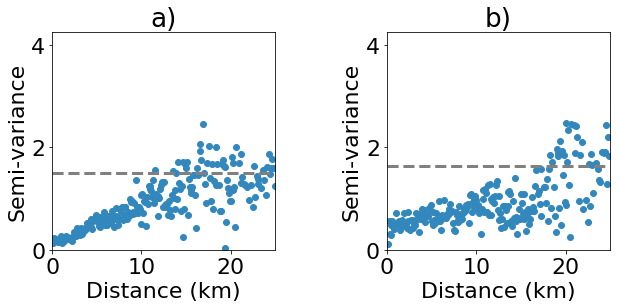

In [95]:
# Observations
r_earth = 6371
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
#fig =plt.figure(figsize=[25,10])
fig =plt.figure(figsize=[10,10])

iii = 1
caption = []
#### clean this data!!!!    
locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values


hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_obs.eps',bbox_inches='tight')

#iii = 1
caption = []
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()

hs = np.linspace(0,25,26)
bandwidth =1# np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_model.eps',bbox_inches='tight')
plt.savefig('figures/fig05.eps',bbox_inches='tight')

skipping 120.0
skipping 41.0
skipping 41.0


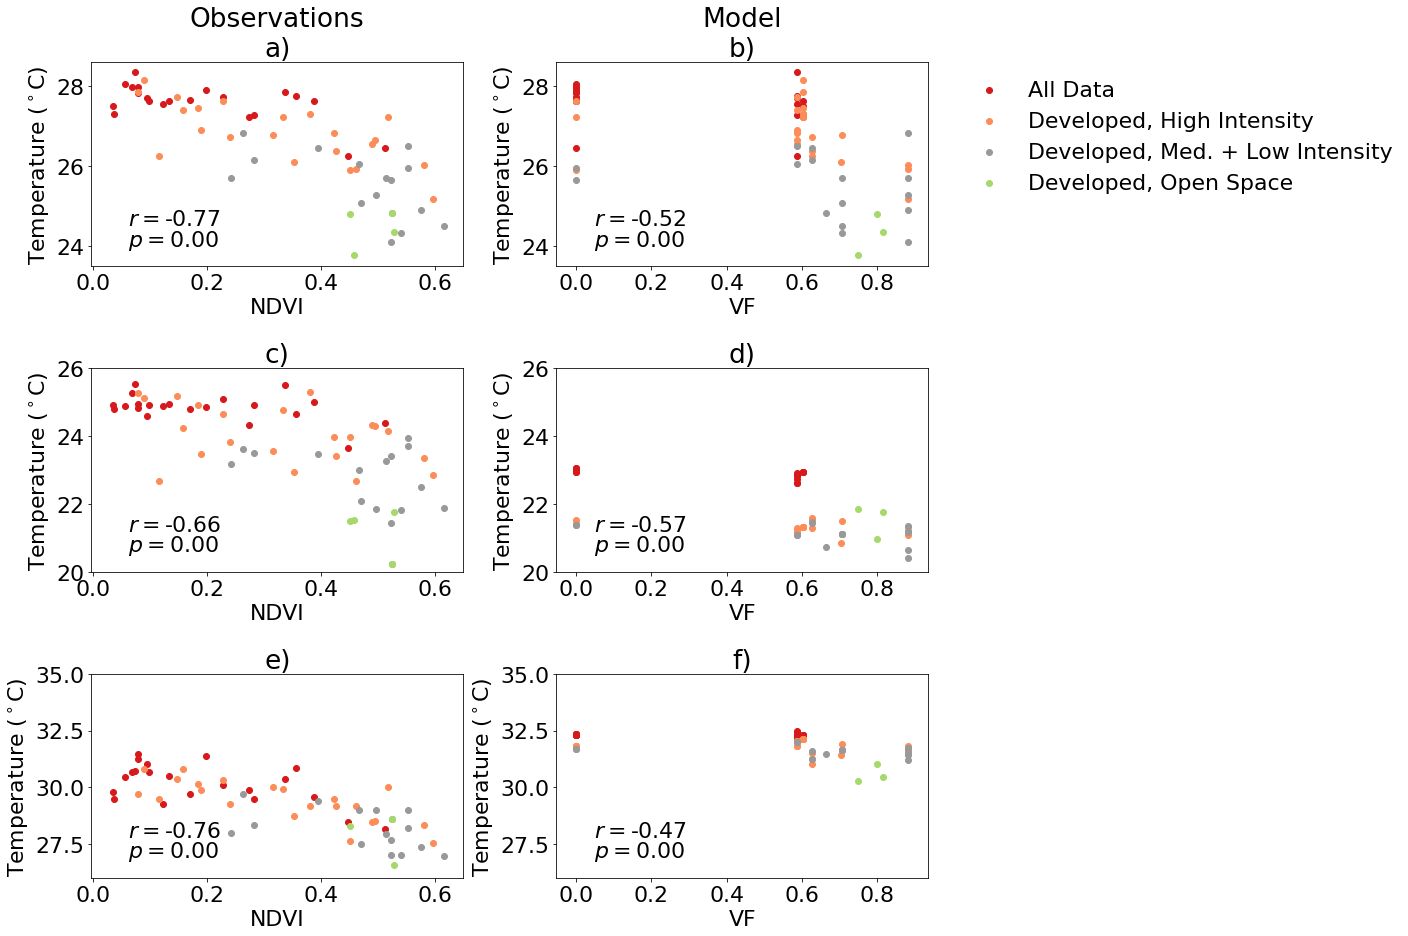

In [96]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
for sensor in sun_sensors: 
    try:
#        lcc.loc[int(sensor)]
        vff.drop(int(sensor), inplace = True)
    except: 
        print('skipping %s'%sensor)
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')
for sensor in sun_sensors: 
    try:
#        lcc.loc[int(sensor)]
        satellitedf.drop(int(sensor), inplace = True)
    except: 
        print('skipping %s'%sensor)
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Observations\na)')

ax = plt.subplot(3,2,2)
x = vff['VF'].astype(float)*.01
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('VF')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Model\nb)')
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01))
ax.legend(labels,bbox_to_anchor=(1.05, 1.01),frameon=False)

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    x = satellitedf['ndvi'].astype(float).dropna()
    y = tempDF[tempDF.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        elif lc ==28: 
            plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
    ax.set_ylim([20,26])

#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    
    ax = plt.subplot(3,2,iii)
    x = vff['VF'].astype(float)*.01
    y = model[model.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('VF')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    ax.set_ylim([20,26])
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.subplot(3,2,5).set_ylim([26,35])
plt.subplot(3,2,6).set_ylim([26,35])
plt.savefig('figures/fig06.eps',bbox_inches='tight')

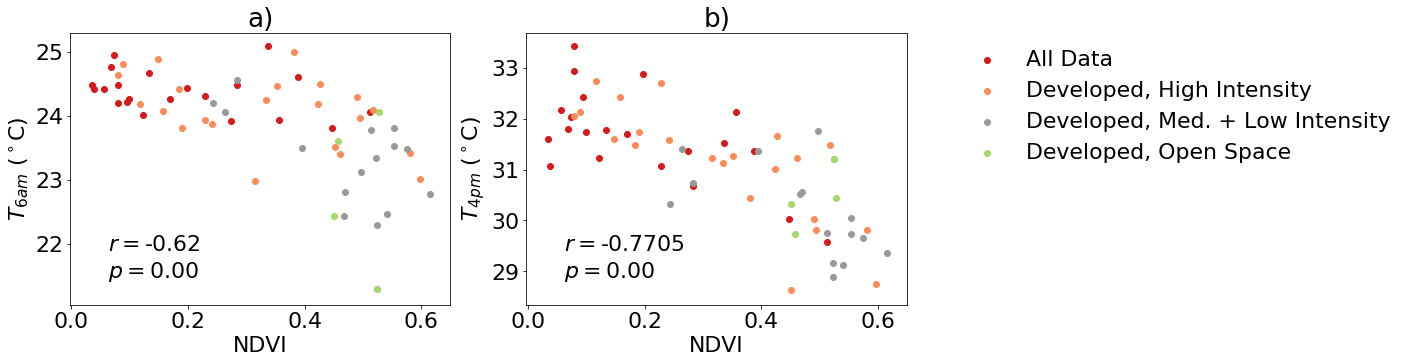

In [97]:
# elevation corrected vegetation 
fig = plt.figure(figsize=[15,5])
i = 1
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{6am}$ ($^\circ$C)')
ax.set_title('a)')
#ax.set_title('Elevation-corrected $T_{min}$\na)')
i = 2
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.4f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{4pm}$ ($^\circ$C)')
#ax.set_title('Elevation-corrected $T_{max}$\nb)')
ax.set_title('b)')
plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.savefig('figures/fig07.eps',bbox_inches='tight')

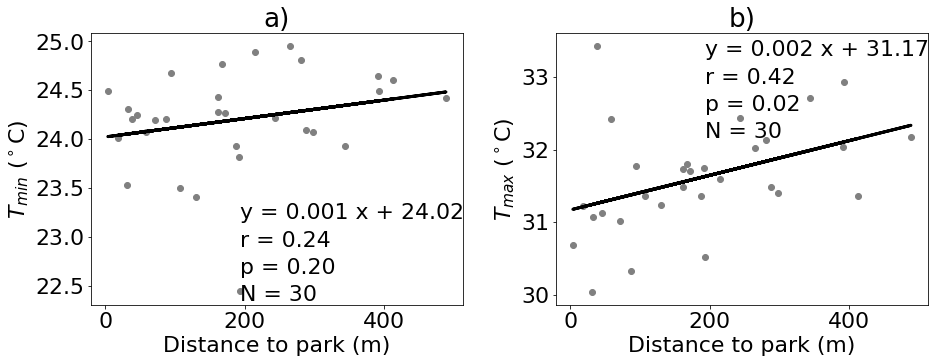

In [98]:
# distance to park, elevation corrected
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
x = distance_to_park
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]

easy_scatter(x[(x < thresh) & (x>0)], 
             y[(x < thresh) & (x>0)], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{min}$ ($^\circ $C)')
ax.set_title('a)')

ax = plt.subplot(1,2,2)
x = distance_to_park
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]
m,r,p = easy_scatter(x[(x < thresh) & (x>0)], 
             y[(x < thresh) & (x>0)], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{max}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
plt.savefig('figures/fig09.eps',bbox_inches='tight')

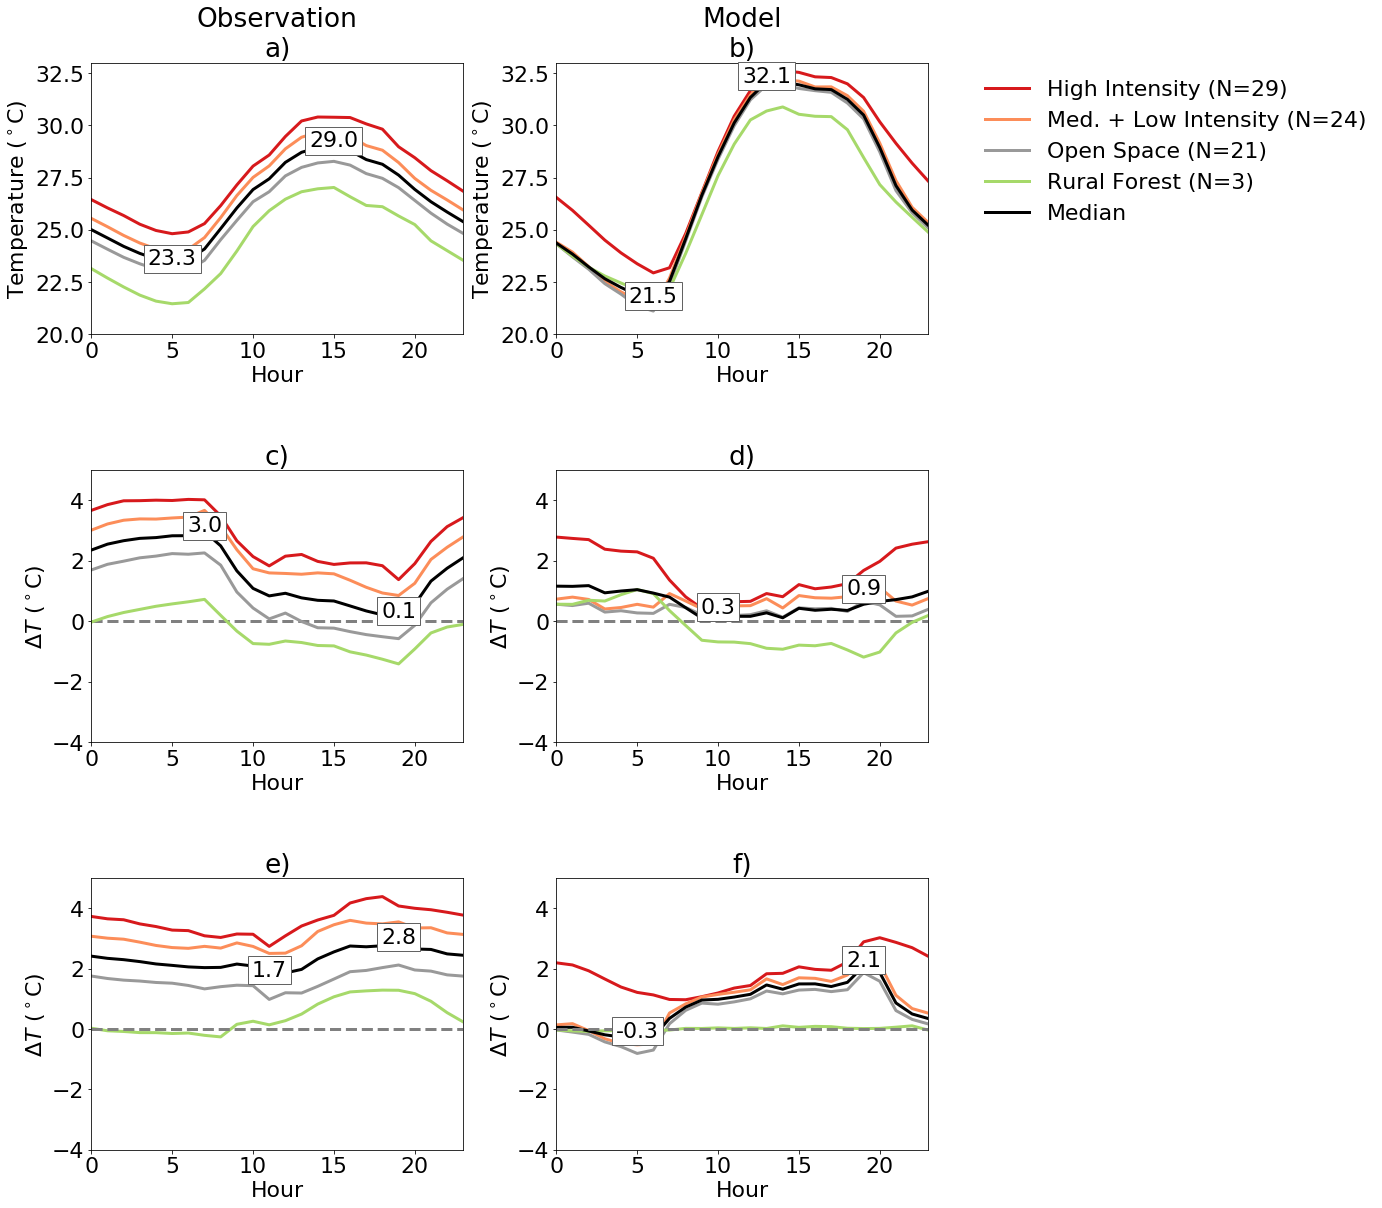

In [100]:
# figure 10 , temperature, DT 
plt.figure(figsize= [15,20])
model_urban =  model[lcc[lcc.LCC ==26].index].groupby(model.index.hour).mean().mean(axis=1)
#model_rural =  model[lcc[lcc.LCC ==28].index].groupby(model.index.hour).mean().mean(axis=1)
model_rural =  model[[130, 103]].groupby(model.index.hour).mean().mean(axis=1)
obs_rural = tempDF[[130, 103]].groupby(tempDF.index.hour).mean().mean(axis=1) # open sites
ax = plt.subplot(3,2,1)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        data = tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='o'].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = 'Urban park (N = %i)'%meta[meta.vesacategory =='o'].index.shape[0] ,ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax = plt.subplot(3,2,2)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        data = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        data = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
        #plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', #'Urban Forest (N=16)', '
          'Median']
plt.legend(labels,#['High Intensity', 'Med. + Low Intensity', 'Open Space', 'Rural Forest', 'Mean'], #labels, 
           bbox_to_anchor=(1.1, 1.01),
               frameon=False)
# plot DT
ax = plt.subplot(3,2,3)
ax.axhline(0, linestyle ='--', color = 'gray')

#tempDF.subtract(tempDF[103], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax, legend = False)
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()
ax.set_title('c)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')

#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4,5])
ax.set_xlabel('Hour')

# plot DT
ax = plt.subplot(3,2,4)
ax.axhline(0, linestyle ='--', color = 'gray')

all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.mean(np.array(all_data),axis=0), color = 'k')
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_title('d)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([-4,5])

# add plot comparing with forested sites
ax = plt.subplot(3,2,5)
obs_rural = tempDF[[68, 75]].groupby(tempDF.index.hour).mean().mean(axis=1) # open sites
#obs_rural = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
#tempDF[meta[meta.vesacategory =='f'].index].groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(label = 'Urban forest (N = %i)'%meta[meta.vesacategory =='f'].index.shape[0] ,ax=ax)
ax.set_title('e)')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')

ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
lc = 26
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
ax.set_xlabel('Hour')
#tempDF.groupby(tempDF.index.hour).mean().mean(axis=1).subtract(obs_rural).plot(color = 'k')    #plt.legend()

ax = plt.subplot(3,2,6)
#model_rural = model_bwi['0'].groupby(model_bwi.index.hour).mean()
model_rural =  model[[68,75]].groupby(model.index.hour).mean().mean(axis=1)
all_data = []
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
#     model_urban.subtract(model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)).plot(label = lcc_english[lc],ax=ax)
    data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot()
    all_data.append(data.values)
plt.plot(np.median(np.array(all_data),axis=0), color = 'k')
ax.set_title('f)')
ax.set_ylim([-4,5])
ax.axhline(0, linestyle ='--', color = 'gray')
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
ax.set_xlabel('Hour')
plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
         np.max(np.median(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
         np.min(np.median(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
#plt.legend(labels,loc=2,frameon=False)
plt.subplots_adjust(hspace=.5,wspace = .25)
plt.savefig('figures/fig10.eps',bbox_inches='tight')

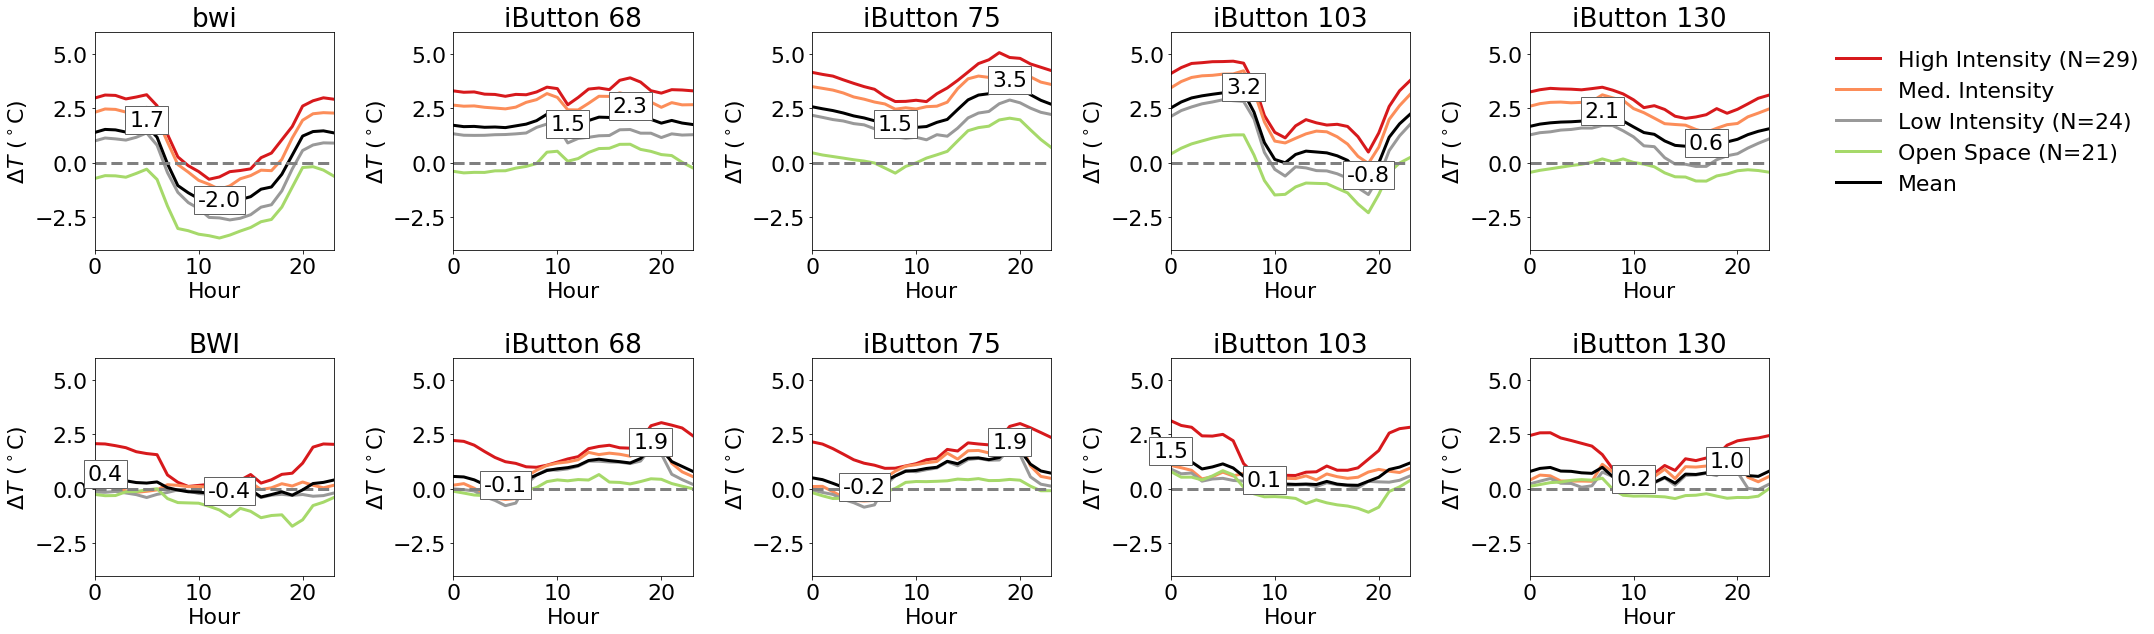

In [99]:
# UHI sensitivity plot 
bwi = obs['rural'][tempDF.index[0]:tempDF.index[-1]].groupby(obs[tempDF.index[0]:tempDF.index[-1]].index.hour).mean()
ibutton = tempDF[[68]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton00 = tempDF[[75]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton01 = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)
ibutton2= tempDF[[130]].groupby(tempDF.index.hour).mean().mean(axis=1)

plt.figure(figsize=[30,10])
i = 1
for obs_rural, title in zip([bwi,ibutton,ibutton00, ibutton01, ibutton2], ['bwi', 'iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(2,5,i)
    all_data =[]
    for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
        if lc ==28: 
            data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().median(axis=1).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
        else: 
            data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().median(axis=1)).subtract(obs_rural)#.plot(label = lcc_english[lc],ax=ax)
        data.plot(ax = ax)
        all_data.append(data.values)
#    ax.plot(np.median(np.array(all_data),axis=0), color = 'k')
    ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
    '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
             np.min(np.mean(np.array(all_data),axis=0)),
     '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )

#     plt.text(np.argmax(np.median(np.array(all_data),axis=0)),
#          np.max(np.median(np.array(all_data),axis=0)),
#     '%2.1f'%(np.max(np.median(np.array(all_data),axis=0))),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     plt.text(np.argmin(np.median(np.array(all_data),axis=0)),
#              np.min(np.median(np.array(all_data),axis=0)),
#      '%2.1f'%(np.min(np.median(np.array(all_data),axis=0))),
#      horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
#      )
#     ax.set_title('c)')
    ax.set_ylabel('$\Delta T$ ($^\circ$C)')
    #plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
    ax.set_ylim([-4, 6])
    ax.set_xlabel('Hour')
    ax.set_title(title)
    ax.axhline(0, linestyle ='--', color = 'gray')

    i = i+1
plt.legend(['High Intensity (N=29)',
 'Med. Intensity',
 'Low Intensity (N=24)',
 'Open Space (N=21)', 'Mean'], bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)


ax = plt.subplot(2,5,i)    
model_rural = np.array(model_bwi.groupby(model_bwi.index.hour).mean()).flatten()#model_bwi.groupby(model_bwi.index.hour).mean().values
all_data =[]
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc ==28: 
        data = model[[68, 75, 130, 103]].groupby(model.index.hour).mean().median(axis=1).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax)
    all_data.append(data.values)    
ax.set_ylabel('$\Delta T$ ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
ax.set_ylim([-4, 6])
ax.set_xlabel('Hour')
ax.set_title('BWI')
ax.axhline(0, linestyle ='--', color = 'gray')

ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
     np.max(np.mean(np.array(all_data),axis=0)),
'%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )
plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
         np.min(np.mean(np.array(all_data),axis=0)),
 '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
 horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
 )

i = i+1
for ibutton, title in zip([68,75,103, 130,], ['iButton 68', 'iButton 75', 'iButton 103', 'iButton 130']): 
    ax = plt.subplot(2,5,i)
    model_rural = model[ibutton].groupby(model.index.hour).mean()
    all_data =[]
    for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
        if lc ==28: 
            data = model[[68, 75, 130, 103]].groupby(model.index.hour).mean().median(axis=1).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
        else: 
            data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1)).subtract(model_rural)#.plot(label = lcc_english[lc],ax=ax)
        data.plot(ax = ax)
        all_data.append(data.values)    
    ax.set_ylabel('$\Delta T$ ($^\circ$C)')
    #plt.legend(np.concatenate([selected_labels.label.values, ['SciCenter ASOS']],axis=0))
    ax.set_ylim([-4, 6])
    ax.set_xlabel('Hour')
    ax.set_title(title)
    ax.axhline(0, linestyle ='--', color = 'gray')
    
    ax.plot(np.mean(np.array(all_data),axis=0), color = 'k')
    plt.text(np.argmax(np.mean(np.array(all_data),axis=0)),
         np.max(np.mean(np.array(all_data),axis=0)),
    '%2.1f'%(np.max(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    plt.text(np.argmin(np.mean(np.array(all_data),axis=0)),
             np.min(np.mean(np.array(all_data),axis=0)),
     '%2.1f'%(np.min(np.mean(np.array(all_data),axis=0))),
     horizontalalignment='center', bbox=dict(facecolor='white', edgecolor = '#636363')
     )
    
    i = i+1

plt.subplots_adjust(wspace=.5, hspace = 0.5)
plt.savefig('figures/fig11.eps', bbox_inches = 'tight')

In [167]:
data = (model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().median(axis=1))#.subtract(model_rural,axis=0)
data

Unnamed: 0
0     26.553708
1     25.933155
2     25.224862
3     24.518651
4     23.899840
5     23.379159
6     22.941881
7     23.186597
8     24.829394
9     26.771713
10    28.748233
11    30.437857
12    31.657594
13    32.500355
14    32.640879
15    32.535139
16    32.319762
17    32.285164
18    31.986544
19    31.330563
20    30.189150
21    29.170188
22    28.262522
23    27.388808
dtype: float64

In [197]:
model_rural = np.array(model_bwi.groupby(model_bwi.index.hour).mean()).flatten()

In [194]:
np.array(model_rural).flatten()

array([ 24.47653899,  23.86998011,  23.24014532,  22.61817457,
        22.19296865,  21.75736474,  21.37156002,  22.54835135,
        24.52474162,  26.67382914,  28.5904658 ,  30.2330602 ,
        31.57722473,  32.33391164,  32.2235906 ,  31.87498118,
        32.05590159,  31.86835429,  31.31884155,  30.61193186,
        28.98695068,  27.22164561,  26.12721812,  25.28313751])

In [195]:
data +(np.array(model_rural).flatten())

Unnamed: 0
0     51.030247
1     49.803135
2     48.465007
3     47.136826
4     46.092809
5     45.136524
6     44.313441
7     45.734949
8     49.354135
9     53.445542
10    57.338698
11    60.670917
12    63.234819
13    64.834266
14    64.864470
15    64.410121
16    64.375664
17    64.153519
18    63.305386
19    61.942495
20    59.176101
21    56.391834
22    54.389740
23    52.671945
dtype: float64

In [198]:
data.subtract(model_rural)

Unnamed: 0
0     2.077169
1     2.063175
2     1.984717
3     1.900477
4     1.706872
5     1.621794
6     1.570321
7     0.638246
8     0.304652
9     0.097884
10    0.157767
11    0.204797
12    0.080369
13    0.166443
14    0.417289
15    0.660158
16    0.263861
17    0.416810
18    0.667703
19    0.718631
20    1.202200
21    1.948543
22    2.135304
23    2.105670
dtype: float64

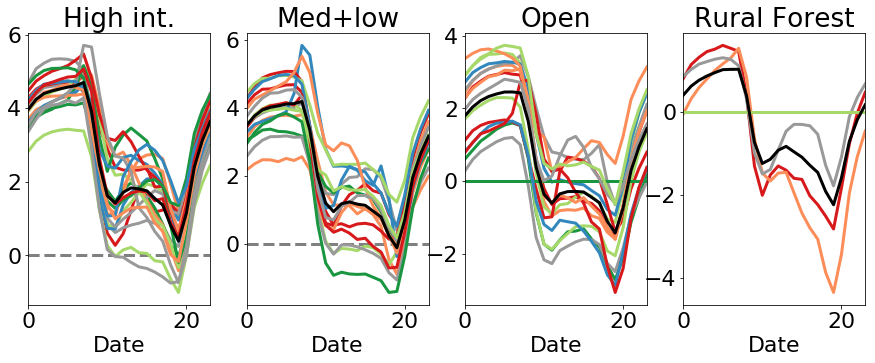

In [62]:
plt.figure(figsize = [15,5])
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
all_data =[]
i = 1
lcs = ['High int.', 'Med+low', 'Open', 'Rural Forest']
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    ax = plt.subplot(1,4, i)
    ax.axhline(0, linestyle ='--', color = 'gray')
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax, legend = False)
    data.mean(axis=1).plot(color = 'k')
    ax.set_title('%s'%lcs[i-1])
    i = i+1
#plt.legend(labels, bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)

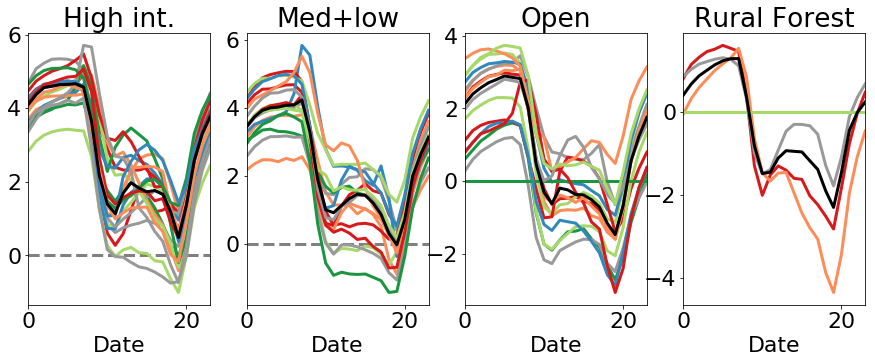

In [63]:
plt.figure(figsize = [15,5])
i = 1
ax = plt.subplot(1,7,i)
obs_rural = tempDF[[103]].groupby(tempDF.index.hour).mean().mean(axis=1)
all_data =[]
lcs = ['High int.', 'Med+low', 'Open', 'Rural Forest']
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    ax = plt.subplot(1,4, i)
    ax.axhline(0, linestyle ='--', color = 'gray')
    if lc ==28: 
        data = tempDF[[68, 75, 130, 103]].groupby(tempDF.index.hour).mean().subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    else: 
        data = (tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean()).subtract(obs_rural, axis=0)#.plot(label = lcc_english[lc],ax=ax)
    data.plot(ax = ax, legend = False)
    data.median(axis=1).plot(color = 'k')
    ax.set_title('%s'%lcs[i-1])
    i = i+1
#plt.legend(labels, bbox_to_anchor=(1.2, 1.01),loc=2,frameon=False)

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:101: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: invalid value encountered in double_scalars


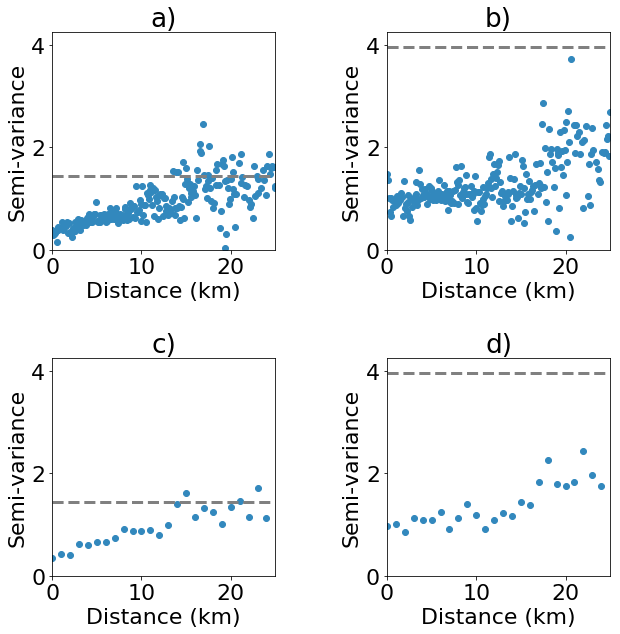

In [530]:
# Observations
r_earth = 6371
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
#fig =plt.figure(figsize=[25,10])
fig =plt.figure(figsize=[10,10])

iii = 1
caption = []
#### clean this data!!!!    
locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values


hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_obs.eps',bbox_inches='tight')

#iii = 1
caption = []
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()

hs = np.linspace(0,25,26)
bandwidth =1# np.abs(hs[1]-hs[0])
#    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
label = 'All data'
    # clean data 
for hr in [6,16]: 
    locations = locations0
    data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.savefig('figures/semivariogram_model.eps',bbox_inches='tight')
#plt.savefig('figures/semivariogram.eps',bbox_inches='tight')

In [24]:
tempDF[tempDF.index.hour==6].mean().var(), tempDF[tempDF.index.hour==16].mean().var()

(1.4156509742053016, 3.939220389964565)

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars


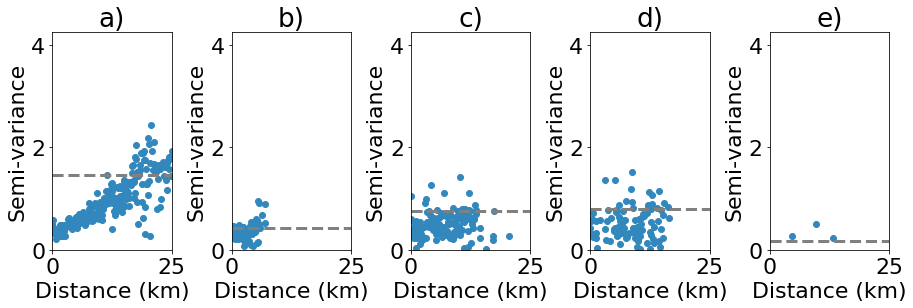

In [74]:
r_earth = 6371
plt.figure(figsize = [15,10])
# pts_df = pts.T.to_pandas()
# pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

locations0 = meta[['location:Longitude', 'location:Latitude']]
data0 = tempDF.mean()

locations1 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==26].index]# np.array([meta['location:Longitude'][lcc[lcc.LCC ==26].index].dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data1 = tempDF.mean()[lcc[lcc.LCC ==26].index]

locations2 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data2= tempDF.mean()[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]#.values

locations3 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==23].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data3= tempDF.mean()[lcc[lcc.LCC ==23].index]#.values

locations4 =  meta[['location:Longitude', 'location:Latitude']].loc[lcc[lcc.LCC ==28].index]#.dropna(), meta['location:Latitude'][lcc[lcc.LCC ==26].index].dropna()]).T
data4= tempDF.mean()[lcc[lcc.LCC ==28].index]#.values

caption = []
hs = np.linspace(0,25,251)
bandwidth =np.abs(hs[1]-hs[0])
iii = 1
for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
#label = 'All data'
    # clean data 
#for hr in [6,16]: 
#     locations = locations0
#     data = tempDF[tempDF.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
    ax = plt.subplot(2,5,iii)
#    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    ax.set_ylim([0,4.25])
    iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)

In [75]:
caption = []
plt.figure(figsize = [15,10])
#### clean this data!!!!    
locations0 = pts_df
data0 = model.mean()

locations1 = pts_df.loc[lcc[lcc.LCC ==26].index]
data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean()

locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index]
data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean()

locations3 = pts_df.loc[lcc[lcc.LCC ==23].index]
data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean()    

locations4 = pts_df.loc[lcc[lcc.LCC ==28].index]
data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean()
iii = 1
hs = np.linspace(0,25,26)
hr = 6
bandwidth =1# np.abs(hs[1]-hs[0])
for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
    #label = 'All data'
    # clean data 
#for hr in [6,16]: 
#     locations = locations0
#     data = tempDF[tempDF.index.hour==hr].mean()
#    data = data[data.index.hour==hr].mean()
    ind = ~np.isnan(locations.iloc[:,0])& ~np.isnan(data)
    data = data[ind].values
    locations = locations[ind].values

    N = data.shape[0]
#    ax = plt.subplot(2,5,iii)
    ax = plt.subplot(2,2,iii)
    semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
    for h in hs:
        Z = []
        for i in range(N): 
            for j in range(i+1,N): 
                #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                if (distance >= h) and (distance< h+bandwidth):
                    Z.append(np.abs(data[i] - data[j])) 
        semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
    ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
    ax.axhline(data.var(), linestyle ='--', color = 'gray')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#        ax.set_title('%s , %i o\'clock '%(label,hr))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Semi-variance')
    #ax.set_ylim([0,1.5])
    ax.set_xlim([0,25])
    caption.append('(%s) %s , %i o\'clock,'%(string.ascii_lowercase[iii-1],label,hr))
    iii = iii+1
    ax.set_ylim([0,4.25])
plt.subplots_adjust(hspace=.5,wspace =0.5)

NameError: name 'pts_df' is not defined

In [322]:
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
len(files)

2353

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars


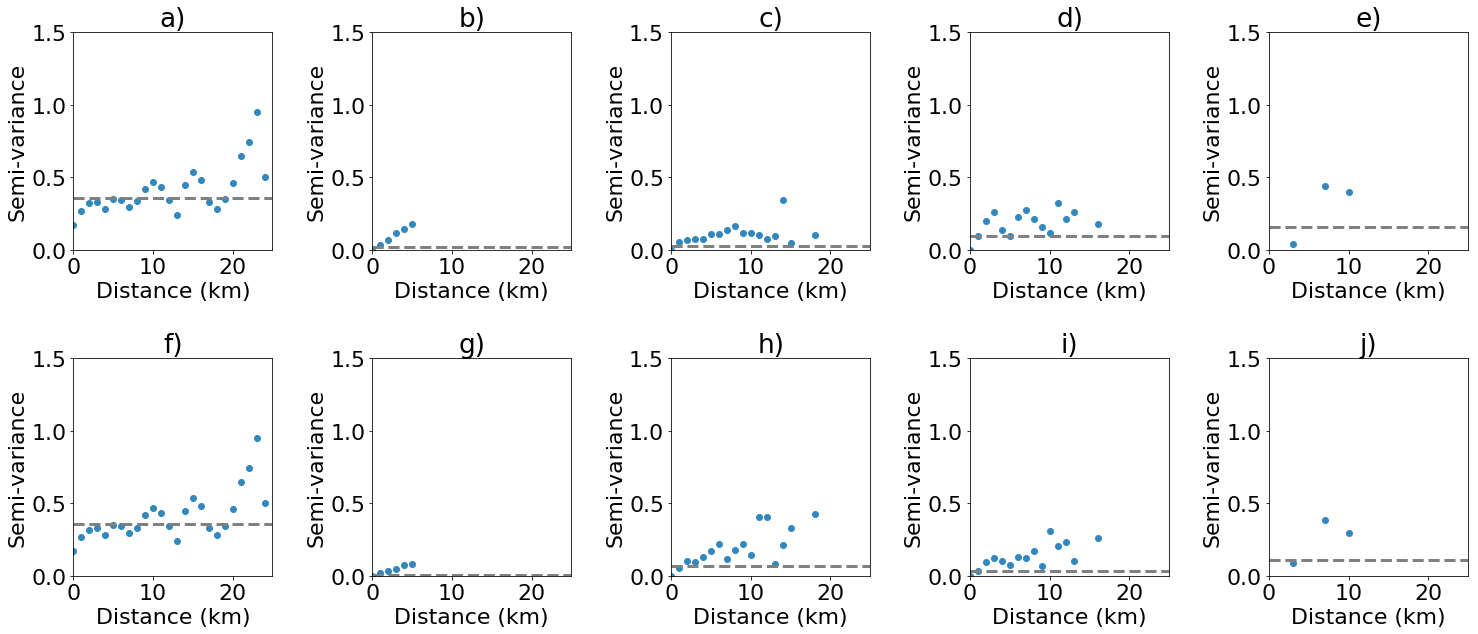

In [323]:
# Model
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
pts = wrf.ll_to_xy(Dataset(files[-1]), meta['location:Latitude'].dropna().values,
                       meta['location:Longitude'].dropna().values)
    
r_earth = 6371
pts_df = pts.T.to_pandas()
pts_df.index = meta['location:Longitude'].dropna().index
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

# labels = ['All Data', 'Developed, Open space + Developed, Low Intensity',
#  'Developed, Medium + High Intensity',
# # 'Developed, High Intensity',
#  'Deciduous Forest']
fig =plt.figure(figsize=[25,10])
iii = 1
for hr in [6,16]: 
    locations0 = pts_df.values
    data0 = model.mean().values
    
    locations1 = pts_df.loc[lcc[lcc.LCC ==26].index].values
    data1 =  model[model.index.hour==hr][lcc[lcc.LCC ==26].index].mean().values
    
    locations2 = pts_df.loc[lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].values
    data2 =  model[model.index.hour==hr][lcc[(lcc.LCC>=24) & (lcc.LCC <=25)].index].mean().values
    
    locations3 = pts_df.loc[lcc[lcc.LCC ==23].index].values
    data3 =  model[model.index.hour==hr][lcc[lcc.LCC ==23].index].mean().values    
    
    locations4 = pts_df.loc[lcc[lcc.LCC ==28].index].values
    data4 =  model[model.index.hour==hr][lcc[lcc.LCC ==28].index].mean().values
    
    hs = np.linspace(0,25,26)
    bandwidth =1# np.abs(hs[1]-hs[0])
    for data,locations,label in zip([data0,data1,data2,data3,data4], [locations0,locations1,locations2, locations3,locations4], labels):
        N = data.shape[0]
        ax = plt.subplot(2,5,iii)
        semivariogram = pd.DataFrame(index = hs, columns= ['semivariogram'])
        for h in hs:
            Z = []
            for i in range(N): 
                for j in range(i+1,N): 
                    #distances[i,j] = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])/360*2*np.pi*r_earth
                    distance = scipy.spatial.distance.euclidean(locations[i,:], locations[j,:])#/360*2*np.pi*r_earth
                    if (distance >= h) and (distance< h+bandwidth):
                        Z.append(np.abs(data[i] - data[j])) 
            semivariogram.loc[h, 'semivariogram']= np.sum(Z)/(2.0*len(Z))
        ax.scatter(semivariogram.index, semivariogram.semivariogram, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][-1])
        ax.axhline(data.var(), linestyle ='--', color = 'gray')
        ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
        #ax.set_title('%s , %i o\'clock '%(label,hr))
        ax.set_xlabel('Distance (km)')
        ax.set_ylabel('Semi-variance')
        ax.set_ylim([0,1.5])
        ax.set_xlim([0,25])

        iii = iii+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.savefig('figures/semivariogram_model.eps')

In [4]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')

In [66]:
satellitedf.drop(sun_sensors)

ValueError: labels [ 41.] not contained in axis

skipping 120.0
skipping 41.0
skipping 41.0


(26, 35)

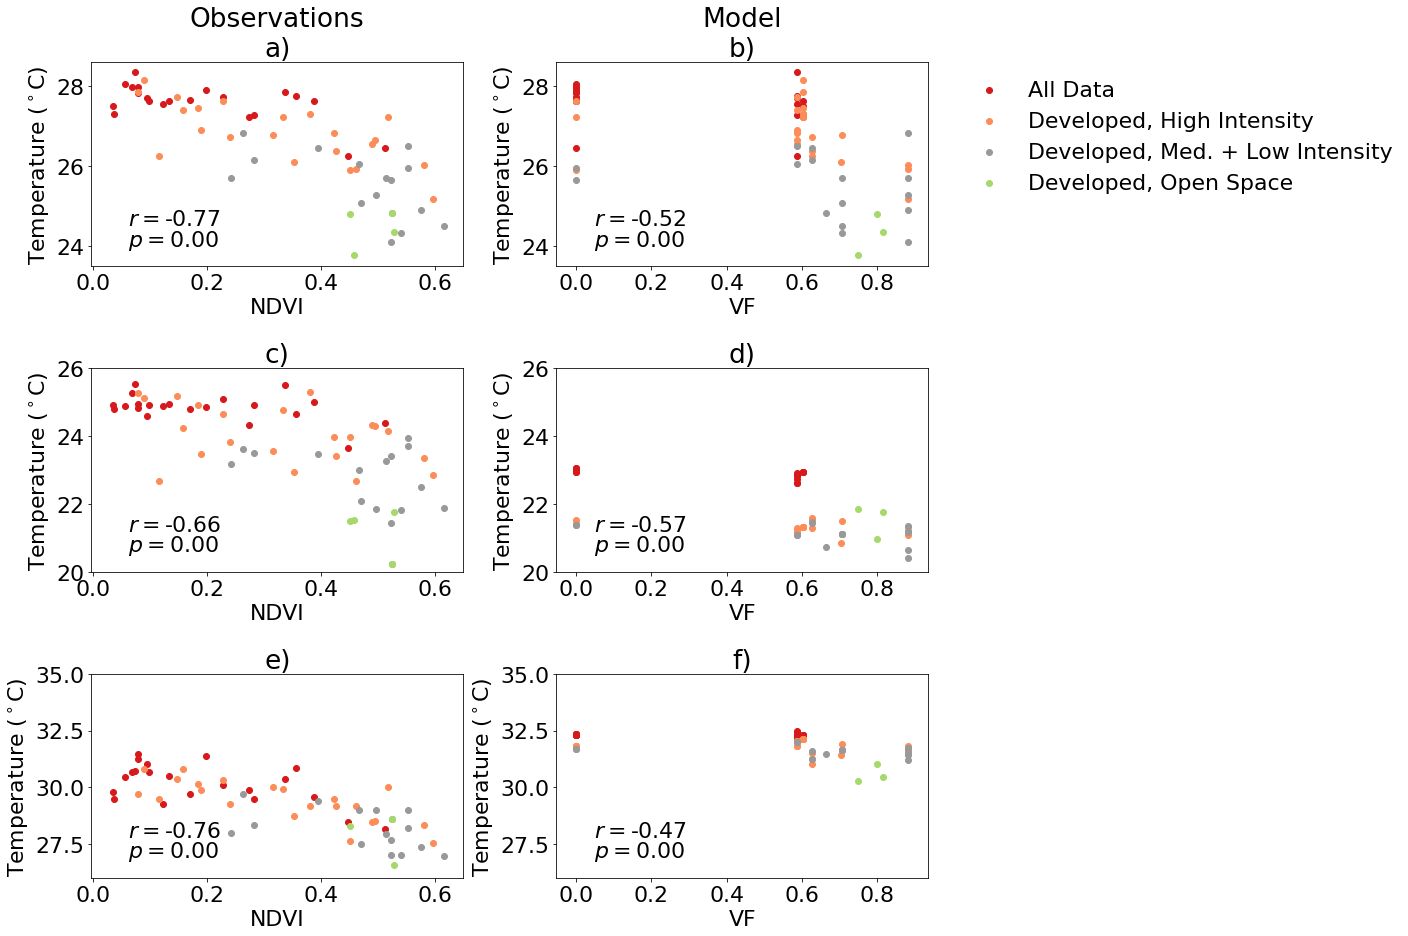

In [67]:
# mean temp vs ndvi/gvf
exp = 'UCM+SST'
dom = 'd03'
vff = pd.read_csv('data/%s_%s_vf.csv'%(exp,dom)).set_index('Unnamed: 0')
for sensor in sun_sensors: 
    try:
#        lcc.loc[int(sensor)]
        vff.drop(int(sensor), inplace = True)
    except: 
        print('skipping %s'%sensor)
satellitedf = pd.read_csv('data/satellite_values.csv').set_index('Unnamed: 0')
for sensor in sun_sensors: 
    try:
#        lcc.loc[int(sensor)]
        satellitedf.drop(int(sensor), inplace = True)
    except: 
        print('skipping %s'%sensor)
labels = ['All Data', 'Developed, High Intensity' ,'Developed, Med. + Low Intensity', 'Developed, Open Space', 'Deciduous Forest']

fig = plt.figure(figsize=[15,15])
ax = plt.subplot(3,2,1)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Observations\na)')

ax = plt.subplot(3,2,2)
x = vff['VF'].astype(float)*.01
y = tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
r,p = scipy.stats.pearsonr(x, y[x.index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('VF')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_title('Model\nb)')
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01))
ax.legend(labels,bbox_to_anchor=(1.05, 1.01),frameon=False)

iii = 3
for hr in [6,16]: 
    ax = plt.subplot(3,2,iii)
    x = satellitedf['ndvi'].astype(float).dropna()
    y = tempDF[tempDF.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        elif lc ==28: 
            plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
    ax.set_ylim([20,26])

#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    
    ax = plt.subplot(3,2,iii)
    x = vff['VF'].astype(float)*.01
    y = model[model.index.hour ==hr].mean()
    #plt.scatter(x, y[x.index])
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
        else: 
            plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
    r,p = scipy.stats.pearsonr(x, y[x.index])
    ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
    ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
    ax.set_xlabel('VF')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax.set_title('%s)'%(string.ascii_lowercase[iii-1]))
#    ax.set_title('%s) %s o\'clock data'%(string.ascii_lowercase[iii-1],hr))
    iii = iii+1
    ax.set_ylim([20,26])
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
plt.subplot(3,2,5).set_ylim([26,35])
plt.subplot(3,2,6).set_ylim([26,35])
#plt.savefig('figures/vegetation_fraction.eps',bbox_inches='tight')

In [364]:
# correlation between Ndvi and vf
np.corrcoef(satellitedf['ndvi'].dropna(), vff['VF'])

array([[ 1.        ,  0.25482854],
       [ 0.25482854,  1.        ]])

In [628]:
pwd

u'/Users/ascott47/blausteinmount/finalthesischapter'

In [71]:
# # source activate mapping-wrf
# # functions for elevation, distance to park 
# from osgeo import ogr, osr
# import numpy as np
# import os
# import gdal
# import pandas as pd
# import shapely 
# import shapely.wkt
# from shapely.geometry import Point

# filepath = '/Users/ascott47/blausteinmount/cityheat/Bmore/2016/'
# meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
# meta = meta.set_index('sensornumber', drop = False)
# meta = meta.set_index(meta.index.astype('float64'), drop = False)
# lon = meta['location:Longitude'].values
# lat = meta['location:Latitude'].values
# def extract_raster_values(X,Y, rasterfile,x_radius =1, y_radius=1, how = 'none'):
#     # X = lon
#     # Y = lat
#     # x_radius =1
#     # y_radius=1
#     #how = 'none'
#     sourceEPSG = 4326
#     sourceProj = osr.SpatialReference()
#     sourceProj.ImportFromEPSG(sourceEPSG)

#     # Read in raster data to get info on the raster projection
#     layer = gdal.Open(rasterfile)
#     gt =layer.GetGeoTransform()
#     bands = layer.RasterCount

#     rasterProj = osr.SpatialReference()
#     rasterProj.ImportFromWkt(layer.GetProjection())
#     transform = osr.CoordinateTransformation(sourceProj, rasterProj)

#     elevation = np.zeros(X.shape[0])
#     src = layer.GetRasterBand(1)
#     i = 0
#     for xx,yy in zip(X,Y):
#         if ~np.isnan(xx) & ~np.isnan(yy):
#             point = ogr.Geometry(ogr.wkbPoint)
#             point.AddPoint(xx,yy)
#         # reproject the lat/lon point to the projection of the raster data
#             point.Transform(transform)

#             x = point.GetPoints()[0][0]
#             y = point.GetPoints()[0][1]

#             rasterx = int((x - gt[0]) / gt[1])
#             rastery = int((y - gt[3]) / gt[5])
#         else: 
#             elevation[i] = np.nan
#         if (rasterx > 0) & (rastery> 0): 
#             data = src.ReadAsArray(rasterx,rastery, win_xsize=x_radius, win_ysize=y_radius)
#             if data.shape == (1,1) :
#                 elevation[i] = data
#             elif how == 'mean' : # mean of raster data, eg, average number of trees for a given buffer
#                 elevation[i] = data.mean()
#             elif how == 'sum' : # total number of raster data, eg, total number of trees
#                 elevation[i] = data.sum()
#             elif how == 'density' : # compute the density of raster data, ie, tree canopy cover
#                 area = x_radius*y_radius
#                 elevation[i] = data.sum()/area
#             #print layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1)
#         else:
#             print('missing data at ', i)
#             elevation[i] = np.nan
#         i = i+1
#     return elevation

# def compute_distance_to_feature(X,Y,feature_file, feature_name = 'none', calculationProjection = 6347):
# # compute distance from an array of lons/lats to a feature
# # if multiple features in shapefile, specify feature_name
# #feature_file = 'data/Parks_Dissolved_reproj.shp'
# #feature_name = 'none'
# #calculationProjection = 6347
# #X = meta.drop(64, axis=0)['location:Longitude'][selected].values
# #Y = meta.drop(64, axis=0)['location:Latitude'][selected].values
    
#     #feature_file = 'data/Parks_Dissolved_reproj.shp'
#     # Read in shapefile for the feature
#     shapefile = ogr.Open(feature_file)
#     layer = shapefile.GetLayer(0)
    
#     # Select the correct feature
#     if feature_name == 'none': 
#         feature = layer.GetFeature(0)
#         geometry = feature.GetGeometryRef()
#     else: 
#         for i in range(layer.GetFeatureCount()):
#             feature = layer.GetFeature(i)
#             name = feature.GetField('name')
#             if name == feature_name : 
#                 geometry = feature.GetGeometryRef()
    
#     ### Transform
#     # reproject lat/lon values to the raster
#     inSpatialRef = osr.SpatialReference()
#     inSpatialRef.ImportFromEPSG(4326) # lat lon

#     outSpatialRef = osr.SpatialReference()
#     #outSpatialRef = layer.GetSpatialRef()
#     outSpatialRef.ImportFromEPSG(calculationProjection)
    
#     # create the CoordinateTransformation
#     coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
#     # check that the shapefile is in the correct projection
#     if geometry.GetSpatialReference() != outSpatialRef : 
#         # reproject 
#         coordTrans2 = osr.CoordinateTransformation(geometry.GetSpatialReference(), outSpatialRef)
#         geometry.Transform(coordTrans2)
    
#     shape = shapely.wkt.loads(geometry.ExportToWkt())
    
#     i = 0
#     distance_to_park = np.zeros(X.shape)
#     for (x,y) in zip(X,Y): 
#         point = ogr.Geometry(ogr.wkbPoint)
#         point.AddPoint(x,y)
#         point.Transform(coordTrans)
#         distance_to_park[i] = Point(point.GetPoints()[0]).distance(shape)
#         i = i+1
#     #distance_to_park = distance_to_park*2*np.pi/360*6371000.    
#     return distance_to_park
# fp = u'/Users/ascott47/blausteinmount/finalthesischapter/'

# feature_file = fp + 'data/parks/Parks_Dissolved_reproj.shp'
# distance_to_park = compute_distance_to_feature(lon,lat,feature_file, feature_name = 'none')
# pd.DataFrame(distance_to_park, index = meta.index).to_csv(fp + 'data/distance_to_park.csv')

# rasterfile = fp + 'data/BaltimoreDEM'
# elevation = extract_raster_values(lon,lat, rasterfile)
# rasterfile = fp+ 'data/Baltimore_DEM_2015_2.5ft/baltimore2015/dblbnd.adf'

# inds =el[0][np.isnan(el[0])].index
# lon = meta['location:Longitude'][inds].values
# lat = meta['location:Latitude'][inds].values
# elevation2 = extract_raster_values(lon,lat, rasterfile)
# el = pd.DataFrame(elevation, index = meta.index.astype(int))  
# el.loc[inds,0] = elevation2
# el.to_csv(fp + 'data/elevation.csv')

# calculate elevation from DEM 
elevation = pd.read_csv('data/elevation.csv').set_index('sensornumber')['0'].astype(float)
elevation.index = elevation.index.astype(int)
distance_to_park = pd.read_csv('data/distance_to_park.csv').set_index('sensornumber')['0'].astype(float)
distance_to_park.index = distance_to_park.index.astype(int)
for sensor in sun_sensors: 
    try:
#        lcc.loc[int(sensor)]
        distance_to_park.drop(int(sensor), inplace = True)
        elevation.drop(int(sensor), inplace = True)
    except: 
        print('skipping %s'%sensor)
#units are both in meters

In [88]:
def easy_scatter(x,y,title='', xlabel='', ylabel='', text_x = 0.5, text_y = 0.9) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.3f x + %.2f'%(m,b), xy=(text_x, text_y), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(text_x, text_y-.1), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(text_x, text_y-.2), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(text_x, text_y-.3), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

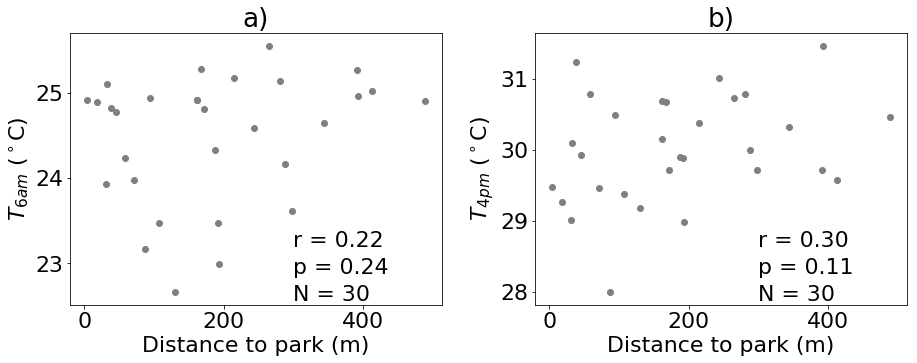

In [85]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==6].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x =0.6, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{6am}$ ($^\circ $C)')
ax.set_title('a)')
ax = plt.subplot(1,2,2)
m,r,p = easy_scatter(distance_to_park[(distance_to_park < thresh) & (distance_to_park >0)], 
             tempDF[tempDF.index.hour==16].mean()[(distance_to_park < thresh) & (distance_to_park >0)], text_x = 0.6, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{4pm}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.savefig('figures/distance_to_park.eps',bbox_inches='tight')

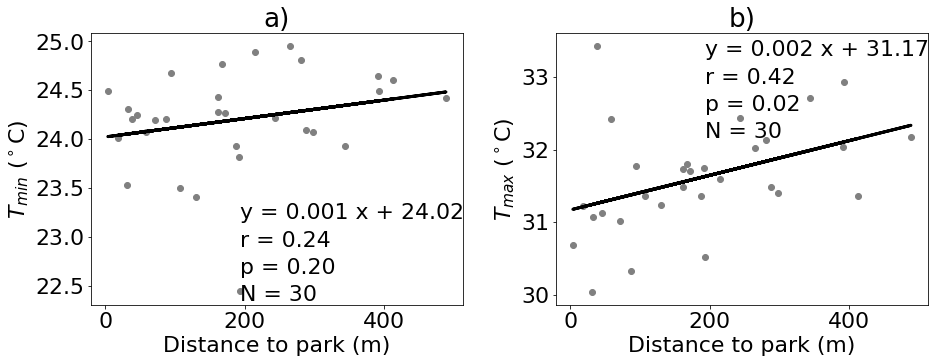

In [89]:
thresh = 500
fig = plt.figure(figsize=[15,5])
ax = plt.subplot(1,2,1)
x = distance_to_park
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]

easy_scatter(x[(x < thresh) & (x>0)], 
             y[(x < thresh) & (x>0)], text_x =0.4, text_y = 0.3)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{min}$ ($^\circ $C)')
ax.set_title('a)')

ax = plt.subplot(1,2,2)
x = distance_to_park
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
x = x[y.index]
m,r,p = easy_scatter(x[(x < thresh) & (x>0)], 
             y[(x < thresh) & (x>0)], text_x = 0.4)
ax.set_xlabel('Distance to park (m)')
ax.set_ylabel('$T_{max}$ ($^\circ $C)')
ax.set_title('b)')
plt.subplots_adjust(hspace=.5,wspace =0.25)
#plt.savefig('figures/distance_to_park_corrected.eps',bbox_inches='tight')

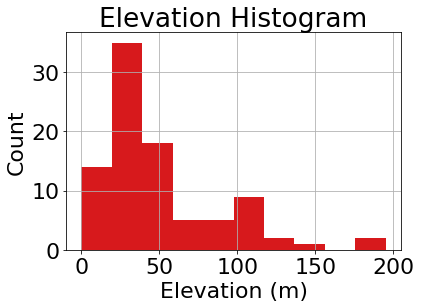

In [777]:
elevation.hist()
plt.xlabel('Elevation (m)')
plt.ylabel('Count')
plt.title('Elevation Histogram')

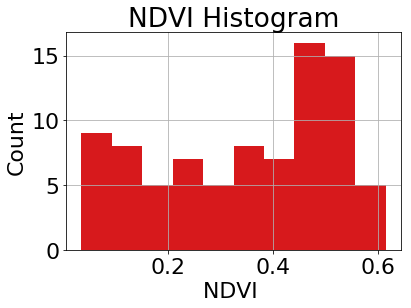

In [723]:
satellitedf['ndvi'].hist()
plt.xlabel('NDVI ')
plt.ylabel('Count')
plt.title('NDVI Histogram')

In [730]:
elevation.shape

(91,)

In [728]:
satellitedf['ndvi'].shape

(90,)

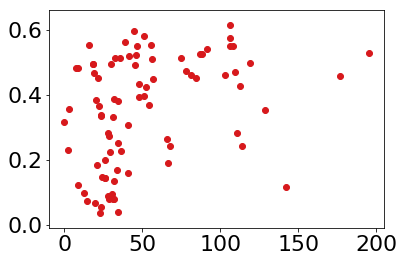

In [778]:
plt.scatter(elevation[satellitedf['ndvi'].index], satellitedf['ndvi'])

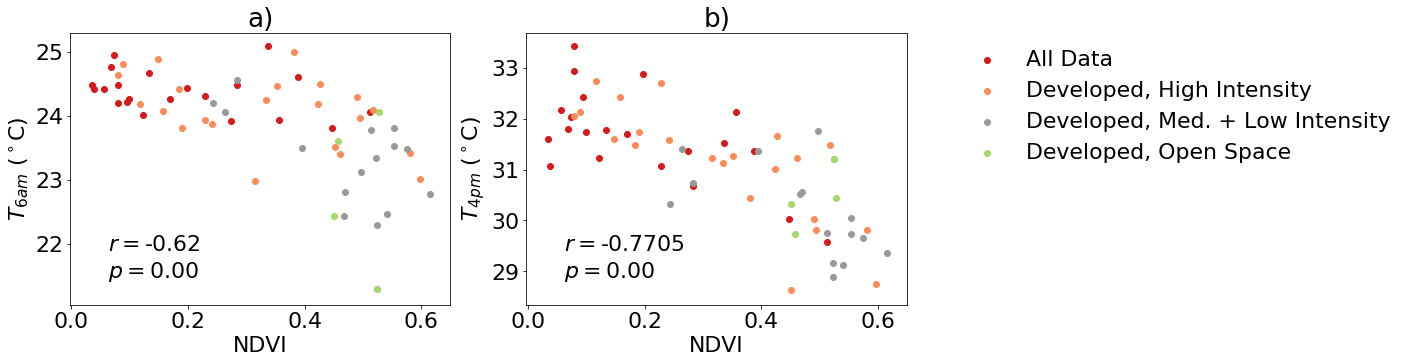

In [90]:
fig = plt.figure(figsize=[15,5])
i = 1
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').min().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.2f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{6am}$ ($^\circ$C)')
ax.set_title('a)')
#ax.set_title('Elevation-corrected $T_{min}$\na)')
i = 2
ax = plt.subplot(1,2,i)
x = satellitedf['ndvi'].astype(float).dropna()
y = tempDF.resample('D').max().mean()[satellitedf.index]+0.015*elevation[satellitedf.index]#tempDF.mean()
#plt.scatter(x, y[x.index])
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        plt.scatter(x[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index], y[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index])
    elif lc ==28 : 
        
        plt.scatter(x[[68, 75, 130, 103]], y[[68, 75, 130, 103]])

    else: 
        plt.scatter(x[lcc.LCC==lc], y[lcc[lcc.LCC ==lc].index])
ind = ~np.isnan(x) & ~np.isnan(y)
r,p = scipy.stats.pearsonr(x[ind], y[ind])#x.dropna(), y[x.dropna().index])
ax.annotate('$r=$%2.4f'%r, xy=(.1, .2), xycoords ='axes fraction')
ax.annotate('$p=$%2.2f'%p, xy=(.1, .1), xycoords ='axes fraction')
ax.set_xlabel('NDVI')
ax.set_ylabel('$T_{4pm}$ ($^\circ$C)')
#ax.set_title('Elevation-corrected $T_{max}$\nb)')
ax.set_title('b)')
plt.legend(labels,bbox_to_anchor=(1.1, 1.01),frameon=False)
#plt.savefig('figures/veg_elevation_corrected.eps',bbox_inches='tight')

In [889]:
elevation.describe()

count     91.000000
mean      49.708366
std       38.924711
min        0.000000
25%       23.651491
50%       34.547405
75%       65.936592
max      195.133606
Name: 0, dtype: float64

In [905]:
# elevation correlation in the morning
np.corrcoef(tempDF[tempDF.index.hour==6].mean().dropna(), elevation[tempDF[tempDF.index.hour==6].mean().dropna().index])

array([[ 1.        , -0.67507984],
       [-0.67507984,  1.        ]])

In [906]:
# elevation correlation in the afternoon
np.corrcoef(tempDF[tempDF.index.hour==16].mean().dropna(), elevation[tempDF[tempDF.index.hour==16].mean().dropna().index])

array([[ 1.        , -0.45266351],
       [-0.45266351,  1.        ]])

In [918]:
elevation.sort_values(ascending=False)

sensornumber
68     195.133606
75     176.847046
94     141.750946
73     128.807800
64     118.694748
82     113.811424
123    112.591141
127    110.472450
110    109.232605
2      107.854416
4      106.209724
144    106.156052
90     105.899117
5      103.091225
106     91.372444
63      88.374596
103     86.993736
130     84.259598
85      81.424652
9       77.947830
11      74.781677
128     67.646851
79      66.349274
74      65.523911
141     56.771053
137     55.962273
34      55.458912
31      54.215317
131     52.389637
91      52.389637
          ...    
86      27.825989
88      27.793037
139     26.021055
17      26.021055
71      25.724264
99      24.107763
47      23.725058
22      23.577925
124     23.218504
80      22.608877
35      22.358833
43      21.411997
41      21.026052
105     20.801702
24      20.297018
126     19.534195
21      18.842646
109     18.061516
122     18.061516
40      18.061516
44      15.821361
66      14.249324
102     12.281138
136      8.6825

In [921]:
tempDF[tempDF.index.hour==6].mean().sort_values()

103    20.233850
63     21.435407
130    21.494325
75     21.525456
9      21.593931
2      21.632325
3      21.671620
68     21.760489
106    21.832718
64     21.860931
5      21.862046
90     21.883128
110    22.095964
134    22.255204
19     22.299391
144    22.462182
4      22.516538
42     22.589243
85     22.670522
94     22.678735
137    22.720816
20     22.750309
13     22.864882
73     22.949948
21     22.996374
40     23.079391
132    23.159037
82     23.172997
10     23.175112
122    23.197130
         ...    
109    24.524345
108    24.590030
17     24.633472
69     24.643505
97     24.665374
22     24.767833
50     24.778259
65     24.799030
60     24.805423
107    24.817784
71     24.867341
77     24.887636
124    24.900456
88     24.908276
105    24.910718
102    24.916850
80     24.919341
131    24.932685
70     24.937309
78     24.959358
98     25.019112
62     25.101276
86     25.135030
99     25.175620
100    25.268964
126    25.278423
28     25.298489
47     25.5093

In [794]:
test_df = pd.DataFrame({'elevation': elevation[[68,75, 103, 130]], 
             'NDVI': satellitedf['ndvi'][[68,75, 103, 130]], 
            'Elevation cooling': 0.015*test_df['elevation'], 
                       'NDVI cooling':2.91*test_df['NDVI'] })
test_df[['elevation', 'NDVI', 'Elevation cooling', 'NDVI cooling']]

elevation      NDVI  Elevation cooling  NDVI cooling
68   195.133606  0.527851           2.927004      1.536048
75   176.847046  0.457631           2.652706      1.331706
103   86.993736  0.524227           1.304906      1.525501
130   84.259598  0.450265           1.263894      1.310271

In [805]:
# how many sites is cooling probably stronger due to elevation? 
satellitedf[(0.015*elevation -2.91*satellitedf['ndvi'])>0].index.shape

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(26,)

In [803]:
# how many sites is cooling from NDVI more than from elevation? 
satellitedf[(0.015*elevation -2.91*satellitedf['ndvi'])<0].index.shape

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


(59,)

In [808]:
tempDF.shape

(1464, 91)

In [796]:
(0.015*test_df['elevation'] - 2.91*test_df['NDVI'] )>0

68      True
75      True
103    False
130    False
dtype: bool

In [789]:
-0.015*test_df['elevation']

68    -2.927004
75    -2.652706
103   -1.304906
130   -1.263894
Name: elevation, dtype: float64

In [790]:
-2.91*test_df['NDVI']

68    -1.536048
75    -1.331706
103   -1.525501
130   -1.310271
Name: NDVI, dtype: float64

In [783]:
satellitedf['ndvi'][[68,75, 103, 130]]

Unnamed: 0
68     0.527851
75     0.457631
103    0.524227
130    0.450265
Name: ndvi, dtype: float64

In [721]:
elevation.describe()

count     83.000000
mean      42.299055
std       29.630410
min        0.000000
25%       22.913691
50%       31.870153
75%       52.389637
max      118.694748
Name: 0, dtype: float64

In [724]:
satellitedf['ndvi'].describe()

count    85.000000
mean      0.350287
std       0.170060
min       0.035046
25%       0.197813
50%       0.384637
75%       0.494098
max       0.615087
Name: ndvi, dtype: float64

In [928]:
elevation[vars]

sensornumber
83     0.000000
62     2.536470
97     3.095654
132    7.562119
Name: 0, dtype: float64

In [932]:
-2.9*.6

-1.74

In [930]:
vars = elevation.sort_values().index[0:4]
test_df = pd.DataFrame({'elevation': elevation[vars], 
             'NDVI': satellitedf['ndvi'][vars]})
test_df['Elevation cooling']= 0.015*test_df['elevation']
test_df['NDVI cooling'] = 2.91*test_df['NDVI']
test_df[['elevation', 'NDVI', 'Elevation cooling', 'NDVI cooling']]

elevation      NDVI  Elevation cooling  NDVI cooling
sensornumber                                                      
83             0.000000  0.315459           0.000000      0.917985
62             2.536470  0.228532           0.038047      0.665027
97             3.095654  0.356219           0.046435      1.036598
132            7.562119  0.480757           0.113432      1.399004

In [924]:
elevation.sort_values().index[0:4]

Int64Index([83, 62, 97, 132], dtype='int64', name=u'sensornumber')

In [91]:
# for Tmin, temperature 
import statsmodels.formula.api as sm
df = pd.DataFrame({"AirTemp": tempDF.resample('D').min().mean(axis=0), 
                   "Elevation": elevation, 
                   "park_distance": distance_to_park, 
                   'NDVI': satellitedf['ndvi'].astype(float), #.dropna(),
                  })

# inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
# parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
# df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + NDVI", data=df).fit()
print(result.params)
print(result.summary())

Intercept    24.804697
Elevation    -0.016070
NDVI         -2.507100
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                AirTemp   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     78.97
Date:                Thu, 31 May 2018   Prob (F-statistic):           2.08e-17
Time:                        13:40:33   Log-Likelihood:                -54.291
No. Observations:                  62   AIC:                             114.6
Df Residuals:                      59   BIC:                             121.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [92]:
# Tmax
df = pd.DataFrame({"AirTemp": tempDF.resample('D').max().mean(axis=0), 
                   "Elevation": elevation, 
                   "park_distance": distance_to_park, 
                   'NDVI': satellitedf['ndvi'].astype(float), #.dropna(),
                  })

# inPark = {'grass': 1, 'impervious': 0, 'dirt':1, 'grass impervious':0, 'grass impervious dirt': 0 }
# parkyesno = np.array([inPark[x] for x in meta.loc[selected].landcoverclass])
# df['InPark'] = parkyesno

result = sm.ols(formula="AirTemp ~ Elevation + NDVI", data=df).fit()
print(result.params)
print(result.summary())

Intercept    32.569659
Elevation    -0.013390
NDVI         -4.978883
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                AirTemp   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     89.00
Date:                Thu, 31 May 2018   Prob (F-statistic):           1.53e-18
Time:                        13:41:36   Log-Likelihood:                -66.412
No. Observations:                  62   AIC:                             138.8
Df Residuals:                      59   BIC:                             145.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

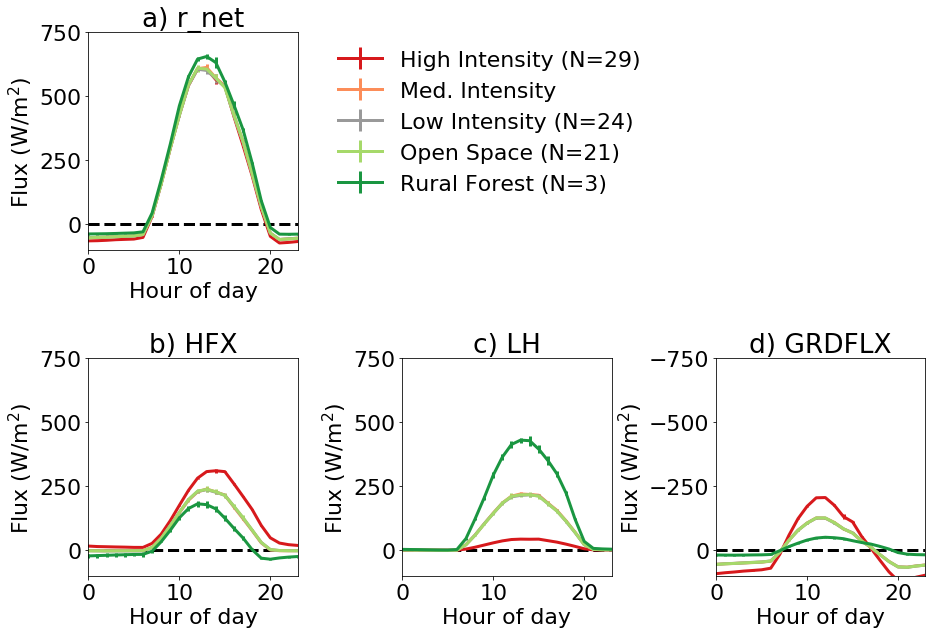

In [230]:
# SEB plots
#em = getvar(dataset_list[-1], 'EMISS')
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') -pd.Timedelta('4h')
model_allvars = pd.read_csv('UCM+SST_d03_allpoints_allvars.csv',header = [0,1], index_col=0,
                        parse_dates = [0], 
                   date_parser = date_parser,
                       skipinitialspace=True)#[tempDF.index[0]:tempDF.index[-1]]
model_allvars.columns.set_levels(model_allvars.columns.levels[1].astype(int), level = 1, inplace = True)
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
rnet = net_lw+net_sw
labels = ['High Intensity (N=29)' ,'Med. Intensity',  'Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)']

fig = plt.figure(figsize=[15,10])
# Plot net 
ax = plt.subplot(2, 3,1)
# #netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
# netflux = rnet - model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']

# for lc in [ 26.,25,24, 23,  28.]:
# #     if lc == 25: 
# #         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
# #             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
# #     else: 
#     netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
#             linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
# plt.title('a) Rnet -LH +H -G')#Average Net Flux')
# plt.xlabel('Hour of day')
# ax.set_ylabel('Flux (W/m$^2$)')
# plt.axhline(0, color ='k', linestyle = '--')

# # plot net radiation 
# ax = plt.subplot(2,3,2)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,24, 23,  28.]:
    rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
    ax.set_ylim([-100,750])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
ax.set_title('a) r_net')
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.axhline(0, color ='k', linestyle = '--')

#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25, 24,23,  28.]:
#         if lc == 25: 
#             data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
#                                                                                                                 label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#         else: 
        data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
#    ax.set_title(var)
    ax.set_ylim([-100,750])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')

# plot ground flux
ax = plt.subplot(2, 3,6)
var = 'GRDFLX'
data = model_allvars.loc[:,var]
for lc in [ 26.,25, 24,23,  28.]:
#         if lc == 25: 
#             data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
#                                                                                                                 label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#         else: 
    data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
ax.set_title('%s) %s'%(string.ascii_lowercase[i-3], var))
#    ax.set_title(var)
ax.set_ylim([-750])
ax.set_xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.xticks([6,12,16])

#plt.ylabel(' (Wm$^{-2}$)')
plt.axhline(0, color ='k', linestyle = '--')
# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',

plt.subplots_adjust(hspace=.5,wspace =0.5)
#plt.legend(bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/SEB.eps', bbox_inches='tight')
# caption: net flux, sensible, latent heat, net radiation

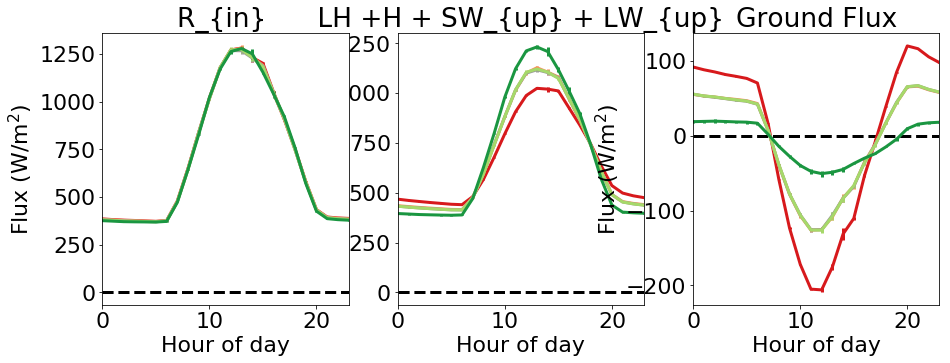

In [226]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,3,2)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title(' LH +H + SW_{up} + LW_{up} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')


ax = plt.subplot(1,3,1)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux = model_allvars.loc[:,'SWDNB'] + model_allvars.loc[:,'LWDNB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title('R_{in} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')

ax = plt.subplot(1,3,3)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'GRDFLX']#+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title('Ground Flux')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')

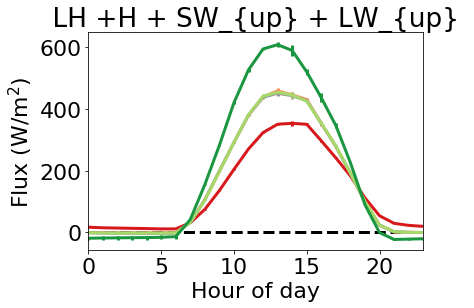

In [227]:
ax = plt.subplot(1,1,1)
#netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
netflux =model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX']# + model_allvars.loc[:,'SWUPB'] + model_allvars.loc[:,'LWUPB']  

for lc in [ 26.,25,24, 23,  28.]:
#     if lc == 25: 
#         netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
#             label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
#     else: 
    netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.title(' LH +H + SW_{up} + LW_{up} ')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
plt.axhline(0, color ='k', linestyle = '--')


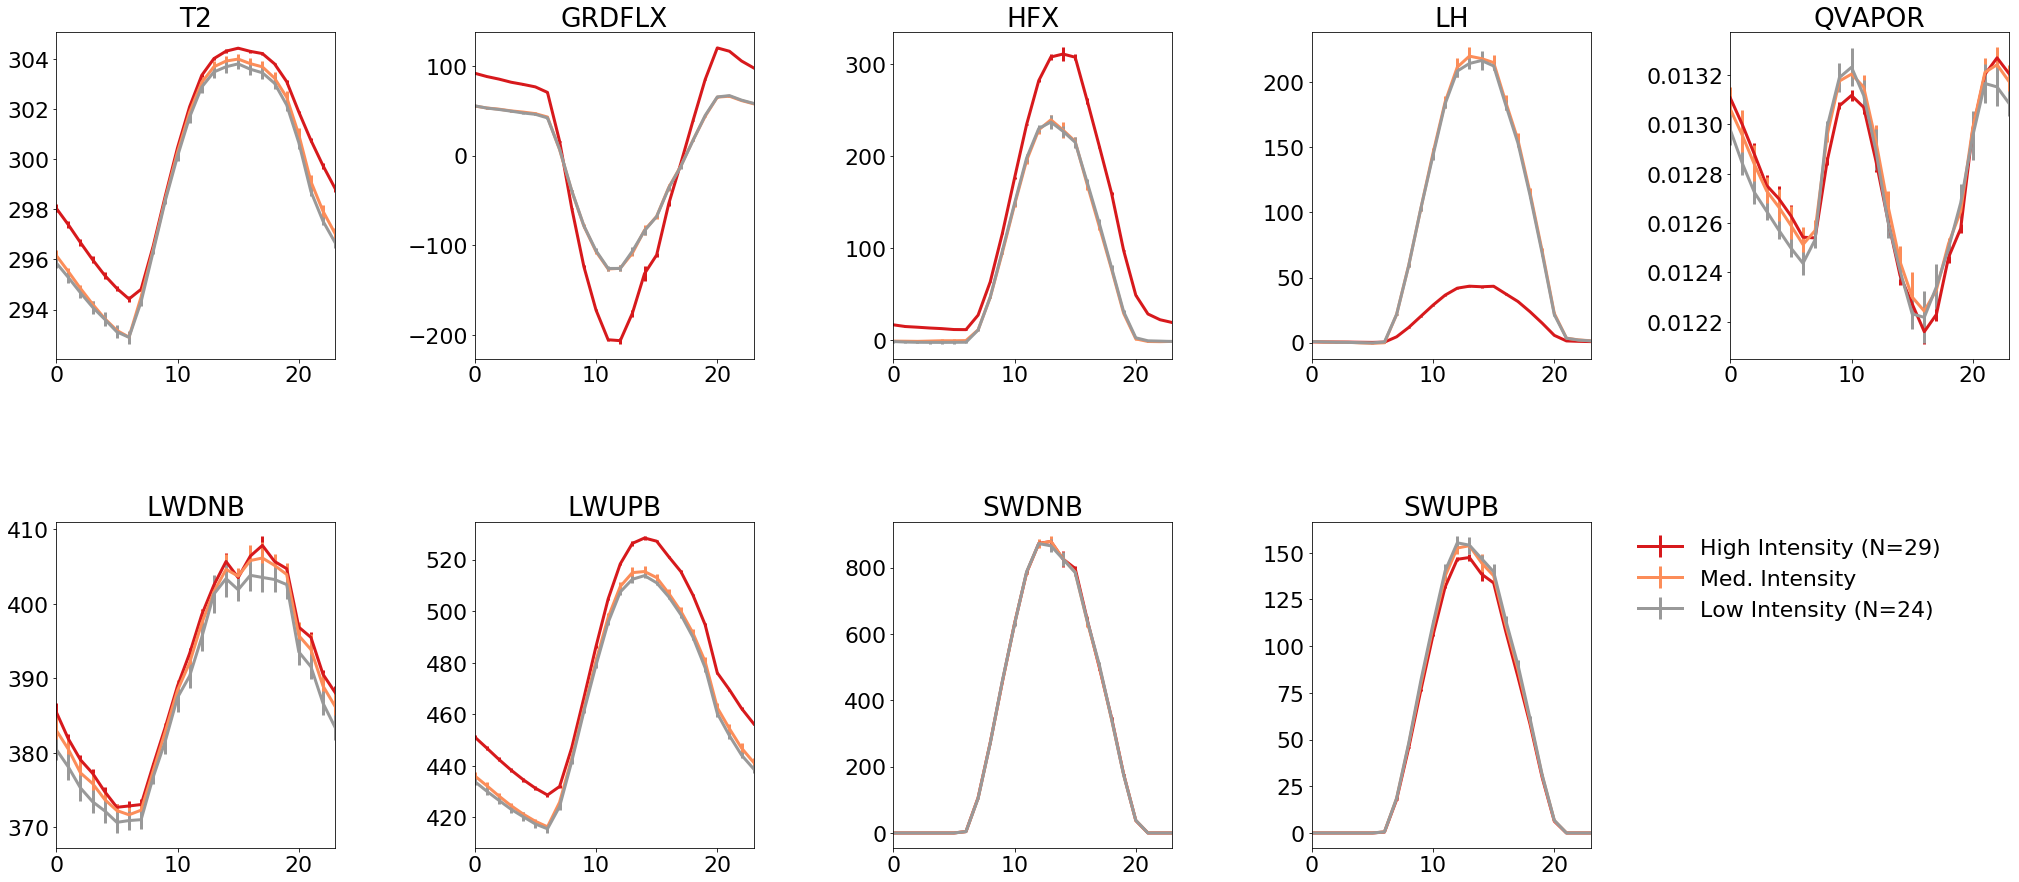

In [39]:
vars= [u'T2', 'GRDFLX', u'HFX', u'LH',u'QVAPOR', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
plt.figure(figsize = [35,15])
i =1
for var in vars: 
    ax = plt.subplot(2,5,i)
    for lc in [ 26.,25, 24]: #,23,  28.]:
#         if lc == 25: 
#             model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(yerr= model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().std(axis=1), ax=ax)
#         else: 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)',
 'Open Space (N=21)',
 'Rural Forest (N=3)',
 'Median'], bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/all_seb_vars.eps')

Fluxes $Q$ in urban grid cells are computed using : 
$$ Q= F_{veg} \cdot Q_{veg} + F_{urban} \cdot Q_{urban}$$
where $F_{veg}$ and $F_{urban}$ are the fraction of vegetated and urban land respectively and $Q_{veg}$ and $Q_{urban}$ are the fluxes from the vegetated and urban land respectively. 
The urban fractions for low, medium, and high intensity land are 0.5, 0.9, and 0.95 respectively, meaning that the urban model contributes very little to the total fluxes in low intensity land compared to medium and high intensity lands.
The model does not save out $Q_{veg}$ and $Q_{urban}$ explicitly, but it is reasonable to assume that $Q_{veg}$ and $Q_{urban}$ are of similar magnitude. This explains why low intensity land differs from other land types. 

To explain why medium and high intensity land differs, we turn to the other parameters, including roof level, roof width, and road width. 

In [38]:
0.47*60

28.2

In [34]:
model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1)

0      -1.980006
1      -2.528372
2      -2.785627
3      -2.872789
4      -2.922914
5      -2.847047
6      -2.718730
7      10.537324
8      46.334042
9      96.736455
10    148.123193
11    197.604975
12    229.702309
13    236.681557
14    226.617817
15    214.725885
16    170.816124
17    126.064353
18     78.445772
19     30.434333
20      2.112919
21     -1.175303
22     -1.514456
23     -1.902089
dtype: float64

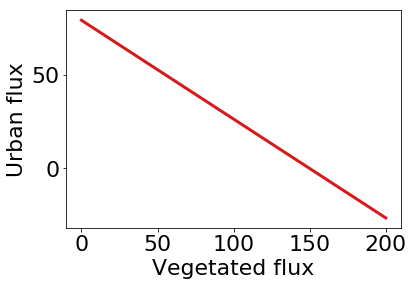

In [37]:
# H = .05*Hv + 0.95
var = 'HFX'
H = model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).mean()
Hv = np.linspace(0,200, 25)
Hu = (75-0.5*Hv)/0.95
plt.plot(Hv, Hu)
plt.xlabel('Vegetated flux')
plt.ylabel('Urban flux')

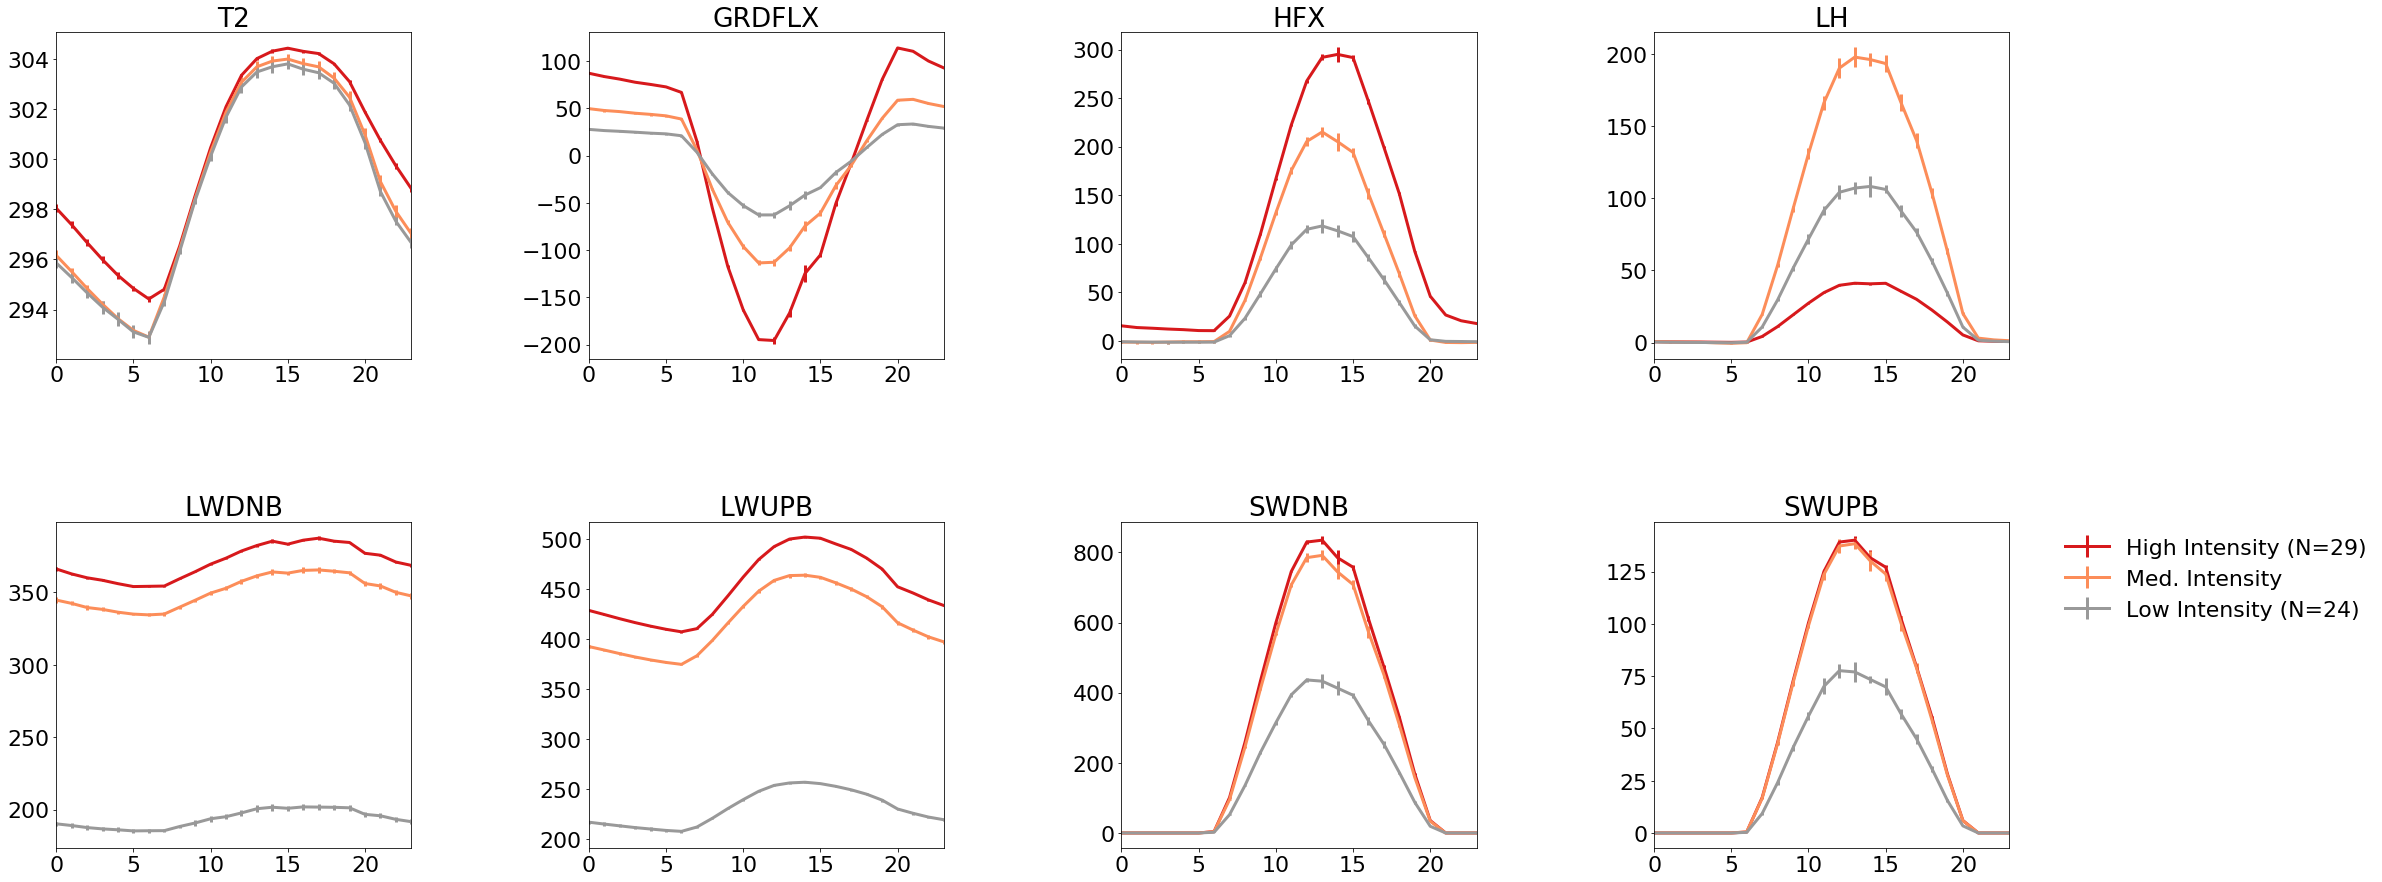

In [40]:
plt.figure(figsize = [35,15])
i = 1
var = 'T2'
ax = plt.subplot(2,4,i)
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
ax.set_title('%s'%var)
i =i+1
vars= [ 'GRDFLX', u'HFX', u'LH', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
#         if lc == 25: 
#             model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(yerr= model_allvars[var][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model_allvars.index.hour).mean().std(axis=1), ax=ax)
#         else: 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
plt.subplots_adjust(hspace=.5,wspace =0.5)
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(1.1, 1.01), frameon=False)
plt.savefig('figures/all_seb_vars_times_urban_fraction.eps')

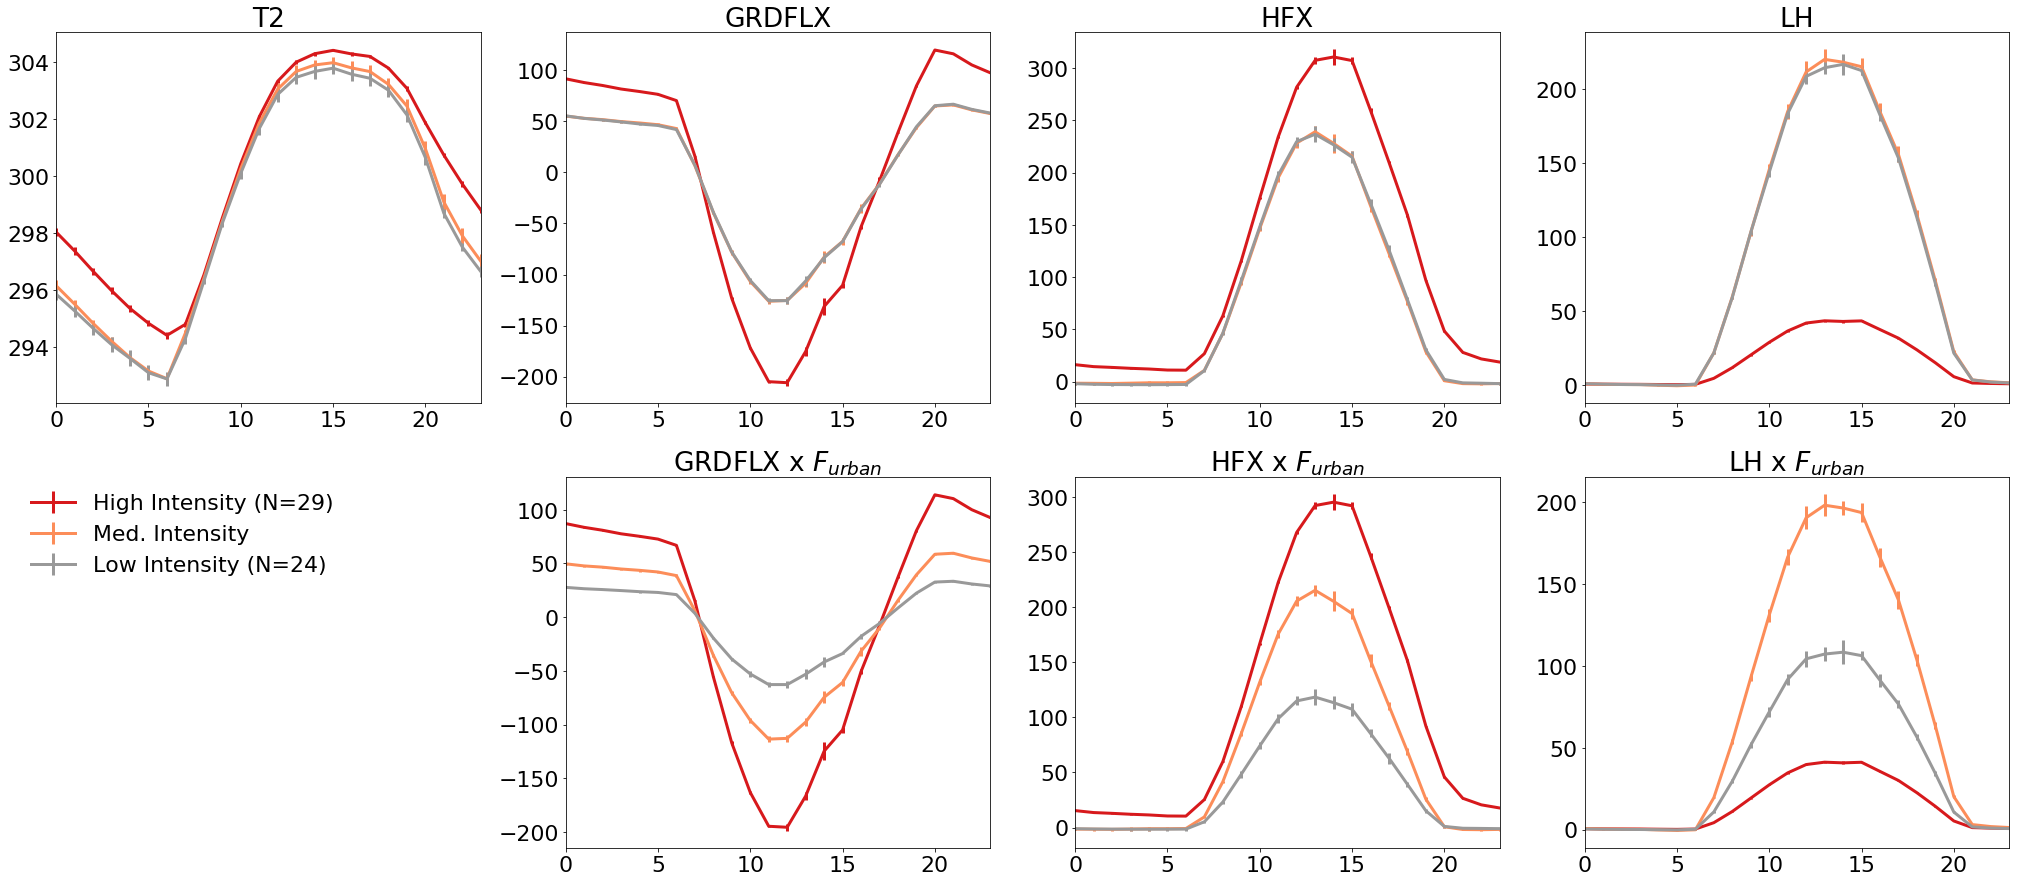

In [53]:
plt.figure(figsize = [35,15])
i = 1
var = 'T2'
ax = plt.subplot(2,4,i)
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
ax.set_title('%s'%var)
i =i+1

vars= ['GRDFLX', u'HFX', u'LH',]#u'QVAPOR', u'LWDNB', u'LWUPB',  u'SWDNB', u'SWUPB']
for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc in [ 26.,25, 24]: #,23,  28.]:
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s'%var)
    i = i+1
    
i = i+1

for var in vars: 
    ax = plt.subplot(2,4,i)
    for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
        model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax, yerr= model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().std(axis=1))
    ax.set_title('%s x $ F_{urban}$'%var)
    i = i+1
    
ax = plt.subplot(2,4,6)    
plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(-0.5, 1.01), frameon=False)
plt.savefig('figures/group_meeting_may9.eps')

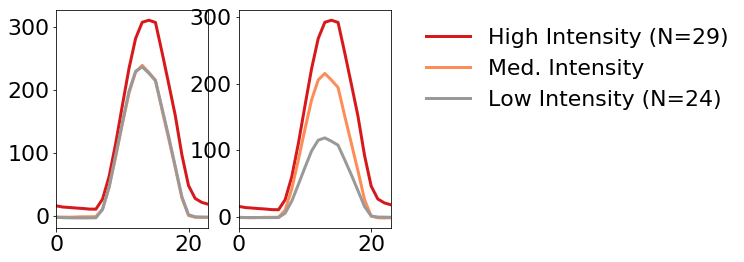

In [31]:
ax = plt.subplot(1,2,1)
var = 'HFX'
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).plot(ax=ax)
ax = plt.subplot(1,2,2)
var = 'HFX'
for lc, f_urban in zip([ 26.,25, 24], [ 0.95, 0.9, 0.5]): 
    model_allvars[var][lcc[lcc.LCC==lc].index].groupby(model_allvars.index.hour).mean().mean(axis=1).multiply(f_urban).plot(ax=ax)


plt.legend(['High Intensity (N=29)',
 'Med. Intensity', 'Low Intensity (N=24)'], bbox_to_anchor=(1.1, 1.01), frameon=False)

- Differences in water fluxes, may explain variability between sites 
- little difference between SW down except for high intensity, could be sky view fraction? 
- 

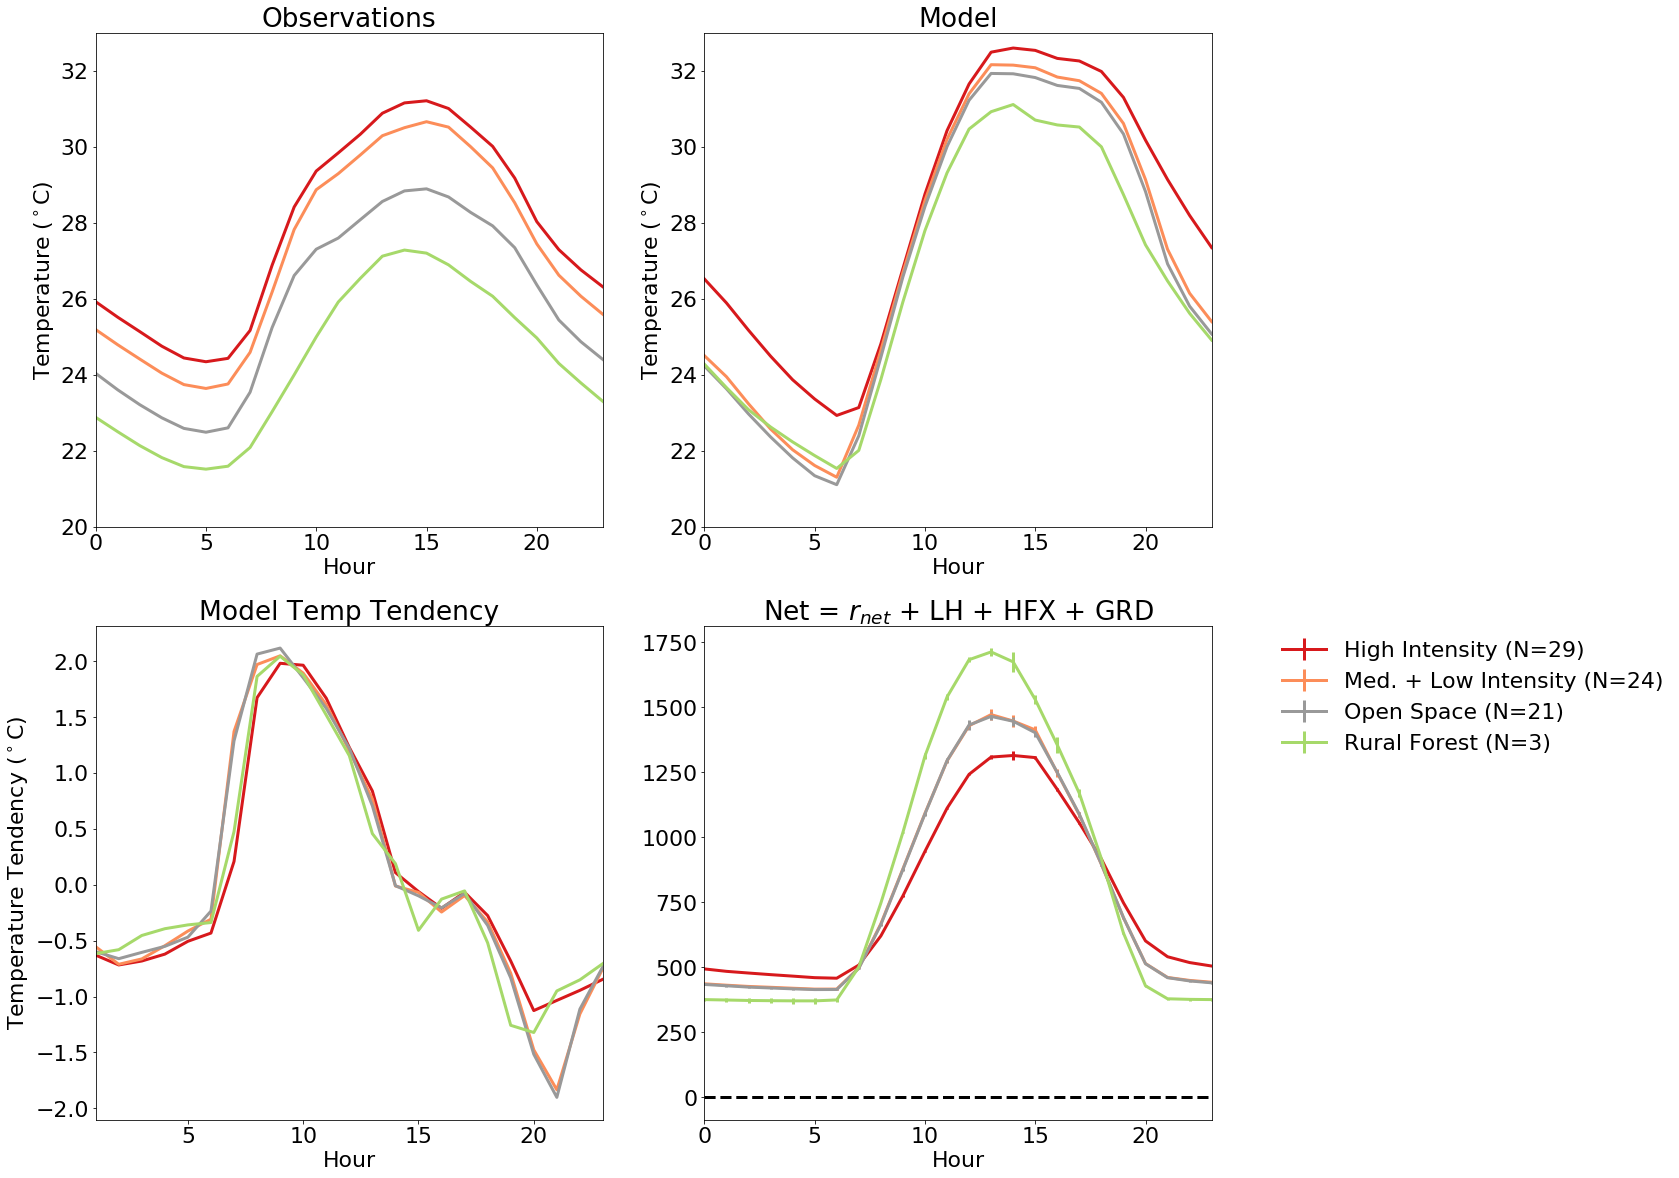

In [289]:
# group meeting slide 
# Temperature, temperature tendency, Flux 

rnet = model_allvars['LWDNB']+net_sw
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']

plt.figure(figsize=[20,20])
ax = plt.subplot(2,2,1)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25: 
        tempDF[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        tempDF[lcc[lcc.LCC ==lc].index].groupby(tempDF.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
ax.set_title('Observation\na)')
ax.set_ylabel('Temperature ($^\circ$C)')
#plt.legend(np.concatenate([selected_labels.label.values, ['ASOS']],axis=0))
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
#labels = ['High Intensity' ,'Med. + Low Intensity', 'Open Space', 'Rural Forest']
labels = ['High Intensity (N=29)' ,'Med. + Low Intensity (N=24)', 'Open Space (N=21)', 'Rural Forest (N=3)', 'Urban Forest (N=16)']
#plt.legend(labels, bbox_to_anchor=(2.2, 1.01),loc=2,frameon=False)
ax.set_title('Observations')

ax = plt.subplot(2,2,2)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
ax.set_title('Model')

ax = plt.subplot(2,2,3)
for lc in [ 26.,25,23,  28.]: #lcc.LCC.unique():
    if lc == 25:
        diurnal = model[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else: 
        diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
    (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values)).plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
#plt.legend()
ax.set_title('Model')
ax.set_ylabel('Temperature Tendency ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_xlabel('Hour')
ax.set_title('Model Temp Tendency')


ax = plt.subplot(2,2,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('Net = $r_{net}$ + LH + HFX + GRD')
#plt.savefig('figures/group_meetingApr11.eps', bbox_inches='tight')

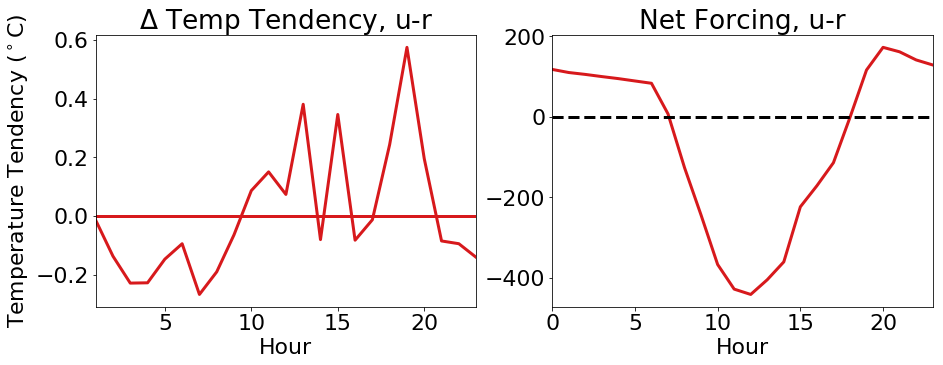

In [292]:
plt.figure(figsize = [15,5])
ax = plt.subplot(1,2,1)
lc = 26
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dT1 = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
lc = 28
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dT2 = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
(dT1-dT2).plot()
ax.set_title('Model')
ax.set_ylabel('Temperature Tendency ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_xlabel('Hour')
ax.set_title('$\Delta$ Temp Tendency, u-r')
ax.axhline(0)

ax = plt.subplot(1,2,2)
rnet = model_allvars['LWDNB']+net_sw
netflux = rnet + model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']
lc = 26
nf1 = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)
lc = 28 
nf2 = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)
(nf1-nf2).plot()
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('Net Forcing, u-r')
#plt.savefig('figures/group_meetingApr11.eps', bbox_inches='tight')

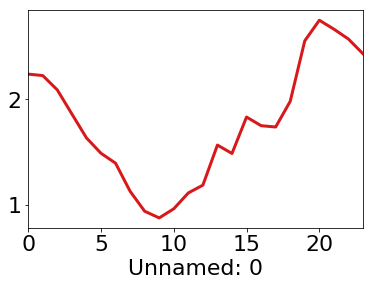

In [294]:
lc = 26
t1 = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
lc = 28 
t2 = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#.plot(label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
(t1-t2).plot()
#plt.legend()
ax.set_title('Model\nb)')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Hour')
#plt.legend()
ax.set_ylim([20,33])
ax.set_xlabel('Hour')
ax.set_title('Model')


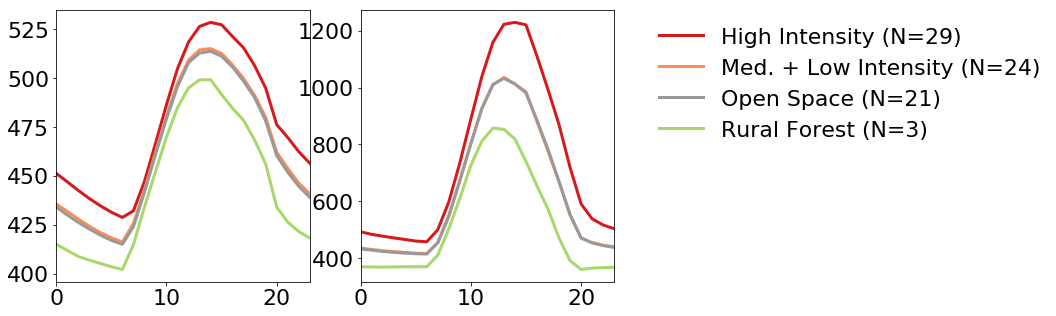

In [319]:
plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        model_allvars['LWUPB'][lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(#yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        model_allvars['LWUPB'][lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot()#yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 

netflux = rnet -model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']
plt.subplot(1,2,2)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(#yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot()#yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)


In [ ]:
netflux

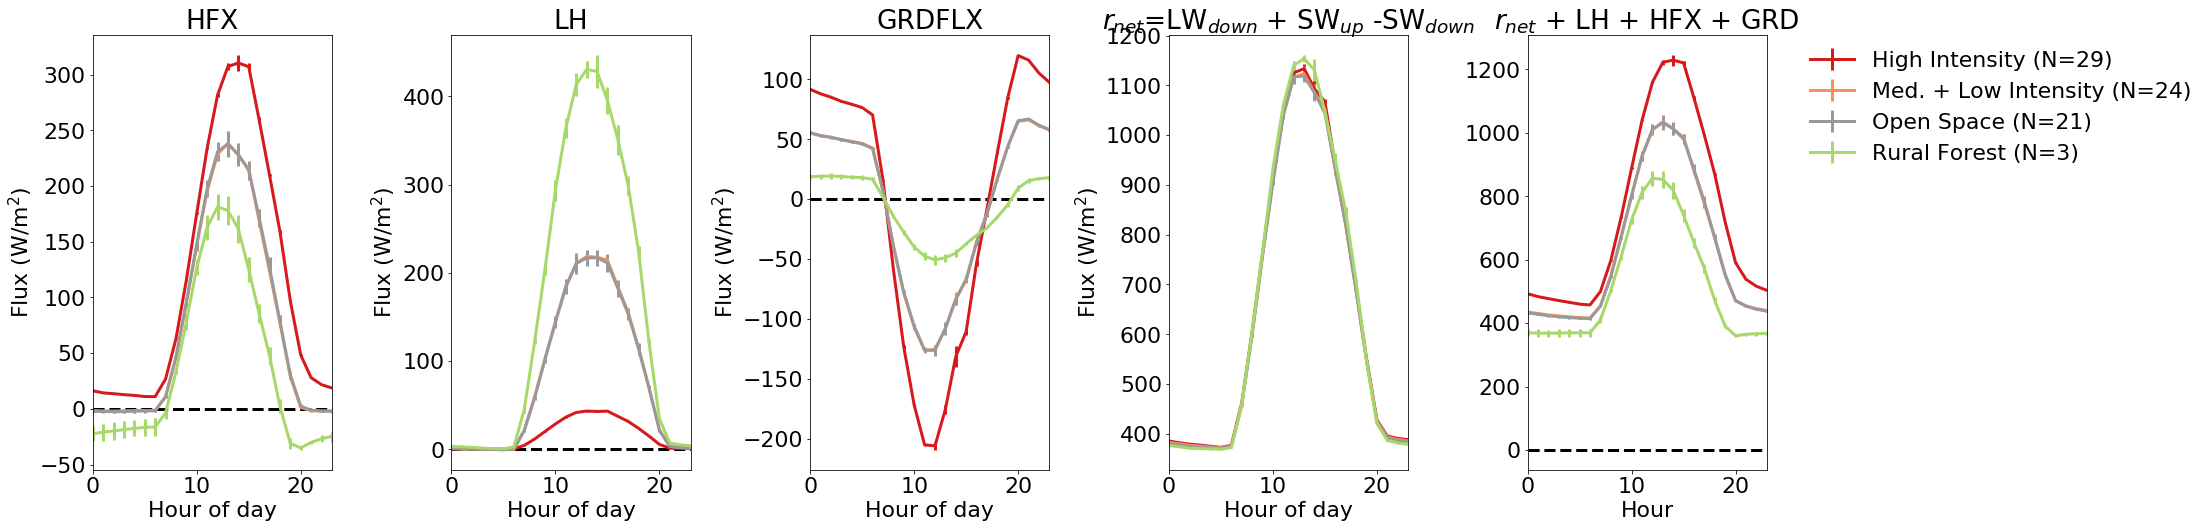

In [312]:
selected_vars = ['HFX','LH','GRDFLX' ]
net_lw = model_allvars['LWDNB'].subtract(model_allvars['LWUPB'])
net_sw = (model_allvars['SWDNB'].subtract(model_allvars['SWUPB']))#.add(model_allvars['net_lw'],axis=0)
#rnet = net_lw+net_sw
rnet = model_allvars['LWDNB']+net_sw
netflux = rnet - model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] + model_allvars.loc[:,'GRDFLX']


plt.figure(figsize=[30,8])
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 1
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(1,5,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_title(var)
    #ax.set_ylim([-100,675])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    plt.axhline(0, color ='k', linestyle = '--')
    

ax = plt.subplot(1,5,4)
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('$r_{net}$=LW$_{down}$ + SW$_{up}$ -SW$_{down}$')#%s)'%(string.ascii_lowercase[i-3]))
    #ax.set_ylim([-100,675])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

ax = plt.subplot(1,5,5)
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
ax.set_xlabel('Hour')
plt.axhline(0, color ='k', linestyle = '--')
plt.title('$r_{net}$ + LH + HFX + GRD')
plt.subplots_adjust(wspace =0.5)

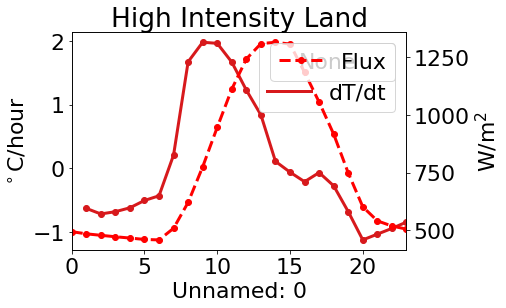

In [299]:
lc = 26 
diurnal = model[lcc[lcc.LCC ==lc].index].groupby(model.index.hour).mean().mean(axis=1)#
dTdt = (diurnal.iloc[1:].subtract(diurnal.iloc[0:-1].values))
flux = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1)

dTdt.plot(style = '-o', label = 'Temp Tendency', )
plt.legend(['dT/dt'], loc=1)
plt.ylabel('$^\circ$C/hour')
flux.plot(secondary_y = True, style = '--or', label = 'Flux')
plt.ylabel('W/m$^2$')
plt.legend(loc=1)
plt.title('High Intensity Land')
plt.xlabel('Hour')
plt.savefig('figures/group_meetingApr11_extra.eps', bbox_inches='tight')

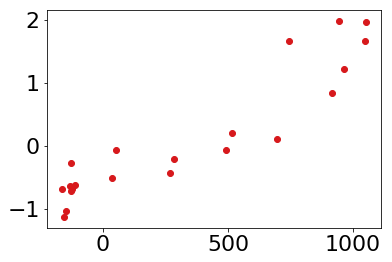

In [836]:
lag = 3
plt.scatter(flux.iloc[lag:].values, dTdt[0:-lag+1].values)
plt.title('')

In [808]:
lag

1

In [826]:
lag

2

In [827]:
flux.iloc[lag:].shape

(22,)

In [828]:
dTdt[0:-lag+1].shape

(22,)

In [835]:
print(np.corrcoef(flux.iloc[1:].values, dTdt.values)[0,1])
for lag in range(2,5) : 
    print(np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1])

0.697461578047
0.846086088951
0.922076955076
0.906947707673


In [825]:
np.corrcoef(flux.iloc[lag:].values, dTdt.values)[0,1]
for lag in range(2,5) : 
    np.corrcoef(flux.iloc[lag:].values, dTdt[0:-lag+1].values)[0,1]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

array([[ 1.        ,  0.65240929],
       [ 0.65240929,  1.        ]])

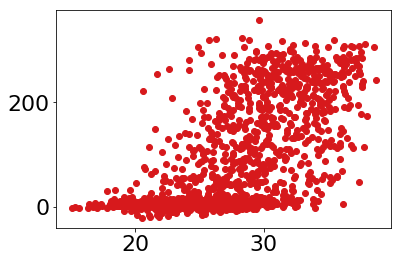

In [309]:
beta = model_allvars['HFX']
plt.scatter(model.mean(axis=1), beta[model.index[0]:model.index[-1]].mean(axis=1))
np.corrcoef(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())

array([[ 1.        ,  0.67561591],
       [ 0.67561591,  1.        ]])

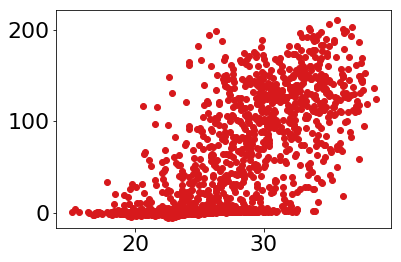

In [311]:
beta = model_allvars['LH']
plt.scatter(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())
np.corrcoef(model.mean(axis=1).dropna(), beta[model.index[0]:model.index[-1]].mean(axis=1).dropna())

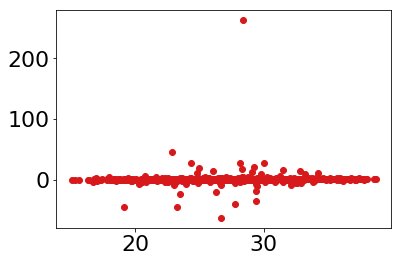

In [306]:
beta = model_allvars['LH']/model_allvars['HFX']
plt.scatter(model.mean(axis=1), beta[model.index[0]:model.index[-1]].mean(axis=1))

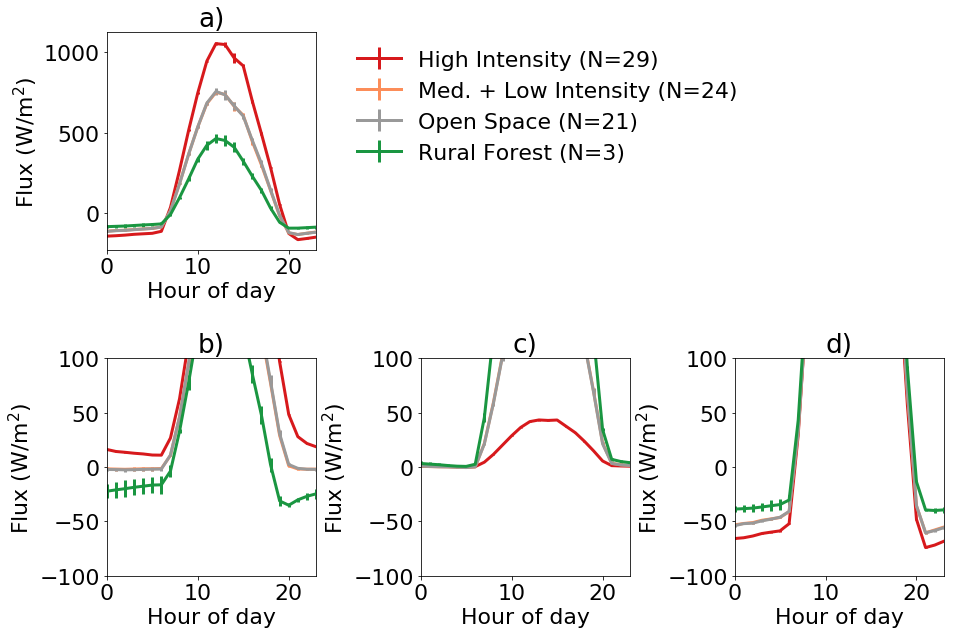

In [789]:
fig = plt.figure(figsize=[15,10])
ax = plt.subplot(2, 3,1)
netflux = rnet -  model_allvars.loc[:,'LH']+ model_allvars.loc[:,'HFX'] -  model_allvars.loc[:,'GRDFLX']
for lc in [ 26.,25,23,  28.]:
    if lc == 25: 
        netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(netflux.index.hour).mean().std(axis=1),
            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    else: 
        netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().mean(axis=1).plot(yerr = netflux[lcc[lcc.LCC==lc].index].groupby(netflux.index.hour).mean().std(axis=1), 
            linewidth = 3,label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
plt.legend(labels, bbox_to_anchor=(1.1, 1.01), frameon=False)
#plt.xticks([6,12,16])
plt.title('a)')#Average Net Flux')
plt.xlabel('Hour of day')
ax.set_ylabel('Flux (W/m$^2$)')
#plt.ylabel(' (Wm$^{-2}$)')

# want: 'R_net', 'Net LW','Sensible', 'Latent', 'Ground flux',
#selected_vars = ['GRDFLX','LH','HFX' ]
selected_vars = ['HFX','LH', ]
#['T2', 'SWDNB', 'SWUPB', 'LWDNB', 'LWUPB', 'LH', 'HFX', 'GRDFLX','CLDFRA', 'QVAPOR',]
#plt.figure(figsize=[20,5])
i = 4
for var in selected_vars:
    #ax = plt.subplot(1, 4,i)
    ax = plt.subplot(2,3,i)
    data = model_allvars.loc[:,var]
    for lc in [ 26.,25,23,  28.]:
        if lc == 25: 
            data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                                label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
        else: 
            data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr = data[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                           label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1]) 
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
#    ax.set_title(var)
    ax.set_ylim([-100,100])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')
    #plt.xticks([6,12,16])
    i = i+1
    
#ax = plt.subplot(1, 4,i)
ax = plt.subplot(2,3,i)
data = model_allvars.loc[:,var]
for lc in [ 26.,25,23,  28.]:
    if lc == 25 : 
        rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr= rnet[lcc[(lcc.LCC <= 25) & (lcc.LCC >=24)].index].groupby(data.index.hour).mean().std(axis=1), 
                                                                                                            label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    else : 
        rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().mean(axis=1).plot(yerr =rnet[lcc[lcc.LCC==lc].index].groupby(data.index.hour).mean().std(axis=1) , 
                                                                                       label = lcc_english[lc] + ' (N = %i)'%model[lcc[lcc.LCC ==lc].index].shape[1],ax=ax)
    ax.set_title('%s)'%(string.ascii_lowercase[i-3]))
    ax.set_ylim([-100,100])
    #plt.xticks([6,12,16])
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Flux (W/m$^2$)')

#ax.set_title('r_net')
plt.subplots_adjust(hspace=.5,wspace =0.5)

In [570]:
em = getvar(Dataset(files[0]), "ALBBCK")
emm = np.diagonal(em.isel(west_east = all_pts.values[0], south_north = all_pts.values[1]), axis1=0,axis2=1)
emissivity = pd.DataFrame(emm, index = meta['location:Latitude'].dropna().index.astype('int64') )
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = emissivity.loc[lcc[lcc.LCC==lc].index].mean().values
    std = emissivity.loc[lcc[lcc.LCC==lc].index].std().values
    print('Albedo : LCC = %i, mean = %2.2f, std = %2.2f'%(lc, mean, std))

Albedo : LCC = 26, mean = 0.10, std = 0.00
Albedo : LCC = 25, mean = 0.10, std = 0.00
Albedo : LCC = 24, mean = 0.11, std = 0.00
Albedo : LCC = 23, mean = 0.12, std = 0.00
Albedo : LCC = 28, mean = 0.15, std = 0.00


In [384]:
em = getvar(Dataset(files[0]), "EMISS")
emm = np.diagonal(em.isel(west_east = all_pts.values[0], south_north = all_pts.values[1]), axis1=0,axis2=1)
emissivity = pd.DataFrame(emm, index = meta['location:Latitude'].dropna().index.astype('int64') )
emissivity

0
sensornumber      
82            0.97
139           0.90
130           0.93
32            0.97
10            0.88
129           0.97
105           0.90
80            0.88
34            0.97
71            0.88
35            0.88
106           0.97
91            0.90
19            0.90
42            0.97
27            0.88
5             0.90
88            0.88
72            0.90
70            0.88
40            0.88
132           0.88
48            0.90
33            0.88
54            0.90
102           0.88
124           0.88
127           0.97
64            0.97
79            0.90
...            ...
73            0.95
41            0.97
103           0.97
123           0.95
50            0.90
108           0.88
12            0.90
100           0.90
137           0.88
77            0.88
22            0.90
90            0.97
31            0.97
92            0.90
2             0.97
110           0.97
11            0.97
141           0.88
126           0.88
78            0.88
62            0.88
24            0.88
75            0.93
65            0.88
85            0.95
29            0.88
144           0.97
21            0.97
134           0.95
44            0.97

[86 rows x 1 columns]

In [413]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = emissivity.loc[lcc[lcc.LCC==lc].index].mean().values
    std = emissivity.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean = 0.88, std = 0.00
LCC = 25, mean = 0.90, std = 0.00
LCC = 24, mean = 0.95, std = 0.00
LCC = 23, mean = 0.97, std = 0.00
LCC = 28, mean = 0.93, std = 0.00


In [418]:
for lc in [26,25,24,23, 28]: #lcc.LCC.unique(): 
    mean = vff.loc[lcc[lcc.LCC==lc].index].mean().values
    std = vff.loc[lcc[lcc.LCC==lc].index].std().values
    print('LCC = %i, mean VF = %2.2f, std = %2.2f'%(lc, mean, std))

LCC = 26, mean VF = 24.53, std = 29.72
LCC = 25, mean VF = 50.75, std = 28.27
LCC = 24, mean VF = 77.44, std = 12.00
LCC = 23, mean VF = 61.81, std = 32.61
LCC = 28, mean VF = 78.80, std = 3.44


In [568]:
exp = 'UCM+SST'
dom = 'd03'
fpath = home_dir + '/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
ds = Dataset(files[0])
all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
                        meta['location:Longitude'].dropna().values)

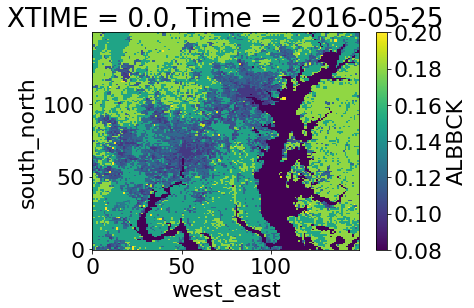

In [567]:
albedo = getvar(ds, "ALBBCK")
albedo.plot()

In [ ]:
albedo.

(<xarray.DataArray u'xy' ()>
 array(10)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.29813979, lon=-76.69014149)
     x_y           <U1 u'y', <xarray.DataArray u'xy' ()>
 array(308)
 Coordinates:
     latlon_coord  object CoordPair(lat=39.28520643, lon=-76.54833725)
     x_y           <U1 u'y')

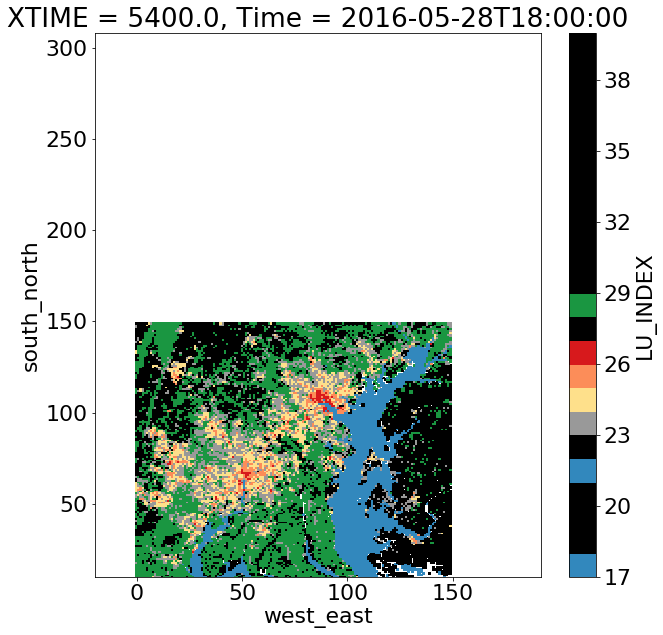

In [720]:
# Fig. 1: A map with insets, some points
# exp = 'UCM+SST'
# dom = 'd03'
# fpath = home_dir + '/mountpoint/wrf/out/'
# files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
# ds = Dataset(files[30*3])
# lu = getvar(ds, "LU_INDEX")
# all_pts = wrf.ll_to_xy(ds, meta['location:Latitude'].dropna().values,
#                        meta['location:Longitude'].dropna().values)
color_dict ={26.: '#d7191c',
             25 : '#fc8d59',
             24: '#fee08b', #'yellow',
             23: '#999999',
             28: '#1a9641', 
             21: '#3288bd',
             17: '#3288bd'
            }
cmap = ['k' for x in range(17,40)]
#cmap = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30', '#762a83','#af8dc3','#e7d4e8',]

for x in color_dict.keys(): 
    x = int(x)
    cmap[x-17] = color_dict[x]
#lu.plot(levels = 24, cmap  = cm.tab20, figsize = [10,10])
lu.plot(levels = 24,  
        cmap = cmap, 
        vmin = 17, vmax =40, figsize = [10,10])
#plt.scatter(all_pts[0], all_pts[1], marker = '^', color = 'k')
# plt.xlim(pts[0].values)
# plt.ylim(pts[1].values)
plt.xlim(pts[0][0]-100, pts[0][1]+100)
plt.ylim(pts[1][0]-100, pts[1][1]+200)

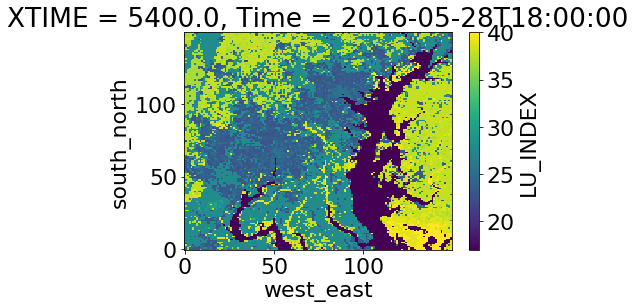

In [721]:
fig = plt.figure()
ax = plt.subplot(1,3,1) 
lu.plot()
ax = plt.subplot(1,3,2) 


In [724]:
ds.variables

OrderedDict([(u'Times', <type 'netCDF4._netCDF4.Variable'>
              |S1 Times(Time, DateStrLen)
              unlimited dimensions: Time
              current shape = (1, 19)
              filling on, default _FillValue of   used),
             (u'XLAT', <type 'netCDF4._netCDF4.Variable'>
              float32 XLAT(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LATITUDE, SOUTH IS NEGATIVE
                  units: degree_north
                  stagger: 
                  coordinates: XLONG XLAT
              unlimited dimensions: Time
              current shape = (1, 150, 150)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'XLONG', <type 'netCDF4._netCDF4.Variable'>
              float32 XLONG(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LONGITUDE, WEST IS NEGATIVE
           